# Goal

The goal of the below data analysis is checking the general trend in Visa applications, the most popular citizenships, employers, cities and finally, predicting the application decision based on the chosen features. 

# What are my metrics?
I used confusion matrix , classification report and AUC-ROC are the metrics used in my project to evaluate the performance of my model . 
<br>
I have binary classification and unbalanced class , so I balanced the class on training set and tested on unbalance target variable class.<br><br><br>
* AUC-ROC is better metric to evaluate model performance .<br>
When the area under the curve is 0.50, this is equivalent to the baseline (chance) prediction.When the area under the curve is 1.00, this is equivalent to perfect prediction.<br>The area under the ROC curve is inherently related to the accuracy
* In my models  area under the curve:<br> random forest=0.83,<br>decisision tree=0.69 and <br>gradient boosting =0.76
-  I choose random forest is best for this project

In [11]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import matplotlib
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
%%time
p_us = pd.read_csv('./us_perm_visas.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

In [3]:
%%time
p_us.shape


Wall time: 0 ns


(374362, 154)

# Walk through your model step by step, starting with EDA
*  starting with EDA , I remove all empty columns and rows
*  I got some columns like (case_number and case_no) ; (country_of_citizenship and country_of_citzenship) which explain same but got different NAN values and I create new column containing only non missing values from both columns.


 

### dropping empty columns and rows

In [4]:
#Dropping all empty columns
p_us = p_us.dropna(axis=1, how='all')

#Dropping all empty rows
p_us =p_us.dropna(axis=0, how='all')
p_us.shape

(374362, 154)

In [5]:
%%time
p_us.columns.values

Wall time: 0 ns


array(['add_these_pw_job_title_9089', 'agent_city', 'agent_firm_name',
       'agent_state', 'application_type', 'case_no', 'case_number',
       'case_received_date', 'case_status', 'class_of_admission',
       'country_of_citizenship', 'country_of_citzenship', 'decision_date',
       'employer_address_1', 'employer_address_2', 'employer_city',
       'employer_country', 'employer_decl_info_title', 'employer_name',
       'employer_num_employees', 'employer_phone', 'employer_phone_ext',
       'employer_postal_code', 'employer_state', 'employer_yr_estab',
       'foreign_worker_info_alt_edu_experience',
       'foreign_worker_info_birth_country', 'foreign_worker_info_city',
       'foreign_worker_info_education',
       'foreign_worker_info_education_other', 'foreign_worker_info_inst',
       'foreign_worker_info_major', 'foreign_worker_info_postal_code',
       'foreign_worker_info_rel_occup_exp',
       'foreign_worker_info_req_experience', 'foreign_worker_info_state',
       'forei

#### case number

In [6]:
%%time

new_df = pd.DataFrame(np.where(p_us.case_no.isnull(),p_us.case_number, p_us.case_no).tolist())

p_us.case_no_final = new_df[0]

Wall time: 72 ms


c:\users\karthik\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [7]:


# p_us.case_no_final

p_us['merged_case_number'] = np.where(p_us.case_no.isnull(),p_us.case_number, p_us.case_no).tolist()

In [8]:
p_us.merged_case_number.isnull().sum
p_us.drop( columns=['case_no', 'case_number'], axis=1, inplace=True)


### Merging citizenship columns

In [9]:
p_us.country_of_citizenship.isnull().value_counts()

False    353729
True      20633
Name: country_of_citizenship, dtype: int64

In [10]:
p_us.country_of_citzenship.isnull().value_counts()

True     353788
False     20574
Name: country_of_citzenship, dtype: int64

In [11]:
p_us['country_of citizenship_merged'] = np.where(p_us.country_of_citizenship.isnull(),
                                                 p_us.country_of_citzenship, 
                                                 p_us.country_of_citizenship).tolist()

In [12]:
p_us.drop( columns=['country_of_citizenship', 'country_of_citzenship'], axis=1, inplace=True)


### case status

In [14]:
df = p_us[p_us.case_status != 'Withdrawn']

In [15]:
df.case_status.value_counts()

Certified            181933
Certified-Expired    148586
Denied                25649
Name: case_status, dtype: int64

In [16]:
df.case_status.dropna(inplace=True) 

c:\users\karthik\anaconda3\lib\site-packages\pandas\core\series.py:2993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [17]:
replace = {'Certified':'Certified/Certified-Expired',
           'Certified-Expired':'Certified/Certified-Expired'}
df['case_status'].replace(replace, inplace=True)

c:\users\karthik\anaconda3\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


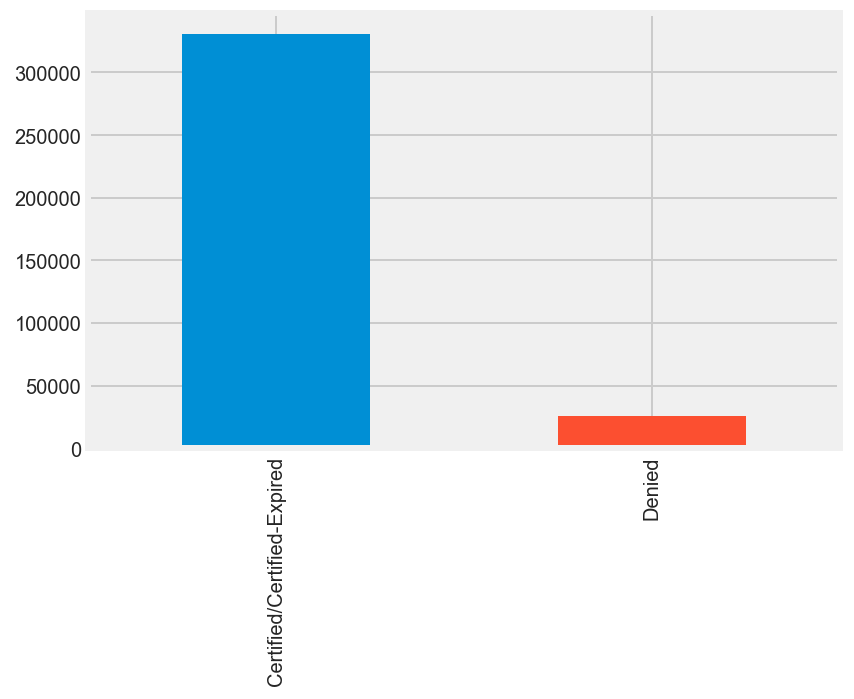

In [18]:
df.case_status.value_counts().plot(kind='bar')

 Number of Visa Applications each year with the case status

## Agent information

In [19]:
df["agent_city"]=df["agent_city"].str.lower()



c:\users\karthik\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
df["agent_city"].tail()

374349     cincinnati
374350        addison
374351    santa clara
374352       new york
374353         edison
Name: agent_city, dtype: object

In [21]:
df["agent_firm_name"]=df["agent_firm_name"].map(lambda x: x if type(x)!=str else x.lower())

c:\users\karthik\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


df['agent_firm_name']=df['agent_firm_name'].replace('fragomen, del rey, bernsen & loewy, llp','fragomen, del rey, bernsen & loewy llp')

In [22]:
# Function to do matching
def search(df, *words):
  """
  Return a sub-DataFrame of those rows whose Name column match all the words.
  """
  return df[np.logical_and.reduce([df.str.contains(word) for word in words])]

In [23]:
df["agent_firm_name2"] = df["agent_firm_name"]
df["agent_firm_name2"].fillna("No", inplace = True)
df["agent_firm_name2"].value_counts()

c:\users\karthik\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\karthik\anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


No                                                157646
fragomen, del rey, bernsen & loewy, llp            30122
berry appleman & leiden llp                        12053
fragomen, del rey, bernsen & loewy llp              3314
seyfarth shaw llp                                   2248
ogletree, deakins, nash, smoak & stewart, p.c.      1937
erickson immigration group                          1741
fakhoury law group                                  1638
murthy law firm                                     1572
ogletree deakins                                    1565
morgan, lewis & bockius llp                         1304
pearl law group                                     1275
egan llp                                            1154
tafapolsky and smith llp                            1129
fragomen, del rey, bernsen, & loewy, llp            1117
cohen & grigsby p.c.                                1003
global labor solutions, llc                          997
ramineni law associates, llc   

In [24]:
%%time
df.loc[search(df["agent_firm_name2"],"law", "mahesh").index,"agent_firm_name2"] = "law offices of mahesh bajoria"
df.loc[search(df["agent_firm_name2"],"fragomen").index,"agent_firm_name2"]='fragomen, del rey, bernsen & loewy llp'
df.loc[search(df["agent_firm_name2"],"berry appleman").index,"agent_firm_name2"]='berry appleman & leiden llp'


c:\users\karthik\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\users\karthik\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\karthik\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Wall time: 6.28 s


c:\users\karthik\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
df.head()

,add_these_pw_job_title_9089,agent_city,agent_firm_name,agent_state,application_type,case_received_date,case_status,class_of_admission,decision_date,employer_address_1,...,us_economic_sector,wage_offer_from_9089,wage_offer_to_9089,wage_offer_unit_of_pay_9089,wage_offered_from_9089,wage_offered_to_9089,wage_offered_unit_of_pay_9089,merged_case_number,country_of citizenship_merged,agent_firm_name2
0,NaN,NaN,NaN,NaN,PERM,NaN,Certified/Certified-Expired,J-1,2012-02-01,24 WEST 25 STREET,...,IT,75629.0,NaN,yr,NaN,NaN,NaN,A-07323-97014,ARMENIA,No
1,NaN,NaN,NaN,NaN,PERM,NaN,Denied,B-2,2011-12-21,200 BROAD STREET,...,Other Economic Sector,37024.0,NaN,yr,NaN,NaN,NaN,A-07332-99439,POLAND,No
2,NaN,NaN,NaN,NaN,PERM,NaN,Certified/Certified-Expired,H-1B,2011-12-01,1054 TECHNOLOGY PARK DRIVE,...,Aerospace,47923.0,NaN,yr,NaN,NaN,NaN,A-07333-99643,INDIA,No
3,NaN,NaN,NaN,NaN,PERM,NaN,Certified/Certified-Expired,B-2,2011-12-01,33-17 PRINCE ST. 2ND FL,...,Other Economic Sector,10.97,NaN,hr,NaN,NaN,NaN,A-07339-01930,SOUTH KOREA,No
4,NaN,NaN,NaN,NaN,PERM,NaN,Certified/Certified-Expired,L-1,2012-01-26,1373 BROADWAY,...,Advanced Mfg,100000.0,NaN,yr,NaN,NaN,NaN,A-07345-03565,CANADA,No


## Decision date

In [26]:
df['decision_date'].head(2)

0    2012-02-01
1    2011-12-21
Name: decision_date, dtype: object

In [27]:
year=pd.DataFrame(df['decision_date'].str.split('-').tolist(),columns=['year','month','day'])

In [28]:
df = df.merge(year, left_index = True, right_index = True,how = 'outer')

In [29]:
df.head(1)

,add_these_pw_job_title_9089,agent_city,agent_firm_name,agent_state,application_type,case_received_date,case_status,class_of_admission,decision_date,employer_address_1,...,wage_offer_unit_of_pay_9089,wage_offered_from_9089,wage_offered_to_9089,wage_offered_unit_of_pay_9089,merged_case_number,country_of citizenship_merged,agent_firm_name2,year,month,day
0,NaN,NaN,NaN,NaN,PERM,NaN,Certified/Certified-Expired,J-1,2012-02-01,24 WEST 25 STREET,...,yr,NaN,NaN,NaN,A-07323-97014,ARMENIA,No,2012,02,01


In [30]:
df.drop(['month','day','decision_date'], axis = 1, inplace = True)

In [31]:

df.head(1)

,add_these_pw_job_title_9089,agent_city,agent_firm_name,agent_state,application_type,case_received_date,case_status,class_of_admission,employer_address_1,employer_address_2,...,wage_offer_from_9089,wage_offer_to_9089,wage_offer_unit_of_pay_9089,wage_offered_from_9089,wage_offered_to_9089,wage_offered_unit_of_pay_9089,merged_case_number,country_of citizenship_merged,agent_firm_name2,year
0,NaN,NaN,NaN,NaN,PERM,NaN,Certified/Certified-Expired,J-1,24 WEST 25 STREET,5TH FLOOR,...,75629.0,NaN,yr,NaN,NaN,NaN,A-07323-97014,ARMENIA,No,2012


[Text(0,0.5,'Number of Visa applicatons'), Text(0.5,0,'Visa application year')]

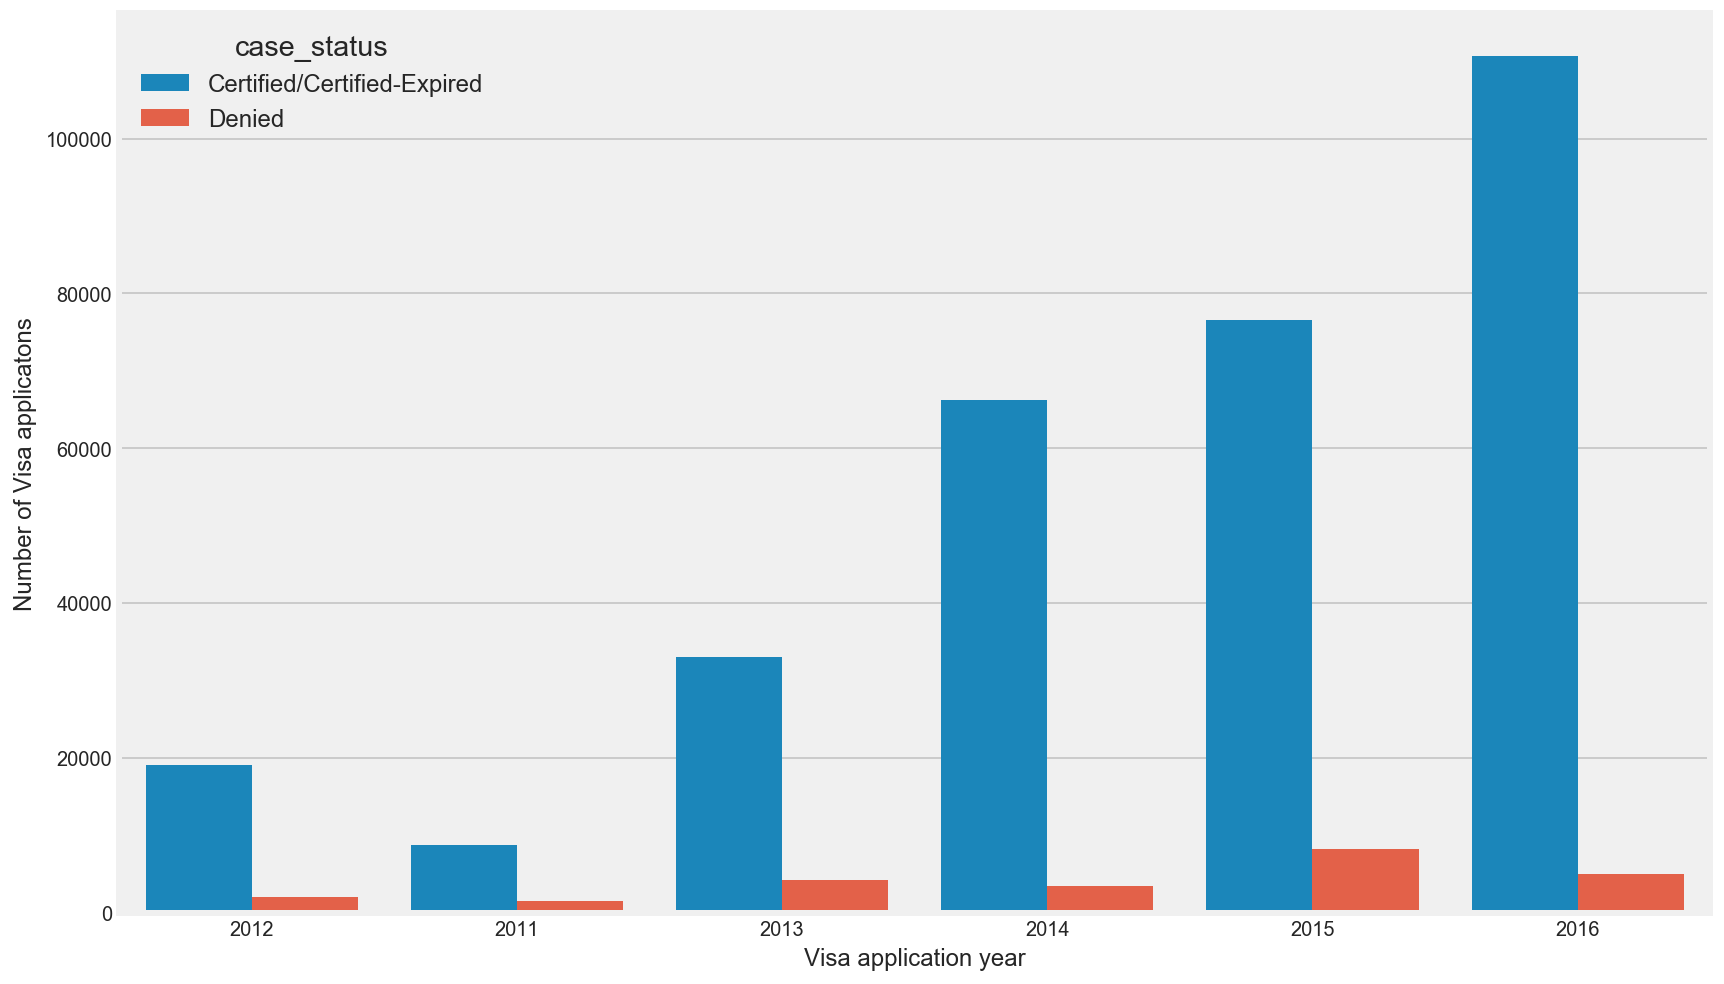

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.set_context(rc={"font.size":12})
sns.countplot(x="year", hue="case_status", data=df)
ax.set(xlabel='Visa application year', ylabel='Number of Visa applicatons')

### Number of people applying for permanent visa increases every year

## Employer information

In [33]:
# Displaying 15 most popular cities
df['employer_city'] = df['employer_city'].str.upper()
df['employer_city'].value_counts().head(15)

NEW YORK           17198
COLLEGE STATION    11985
SANTA CLARA        10519
SAN JOSE            9147
REDMOND             8485
MOUNTAIN VIEW       8121
HOUSTON             6720
SAN FRANCISCO       6352
SUNNYVALE           6104
PLANO               5607
CHICAGO             5561
SEATTLE             5051
EDISON              4056
LOS ANGELES         4045
SAN DIEGO           3702
Name: employer_city, dtype: int64

[Text(0,0.5,'Number of Visa applications'), Text(0.5,0,'Employer city')]

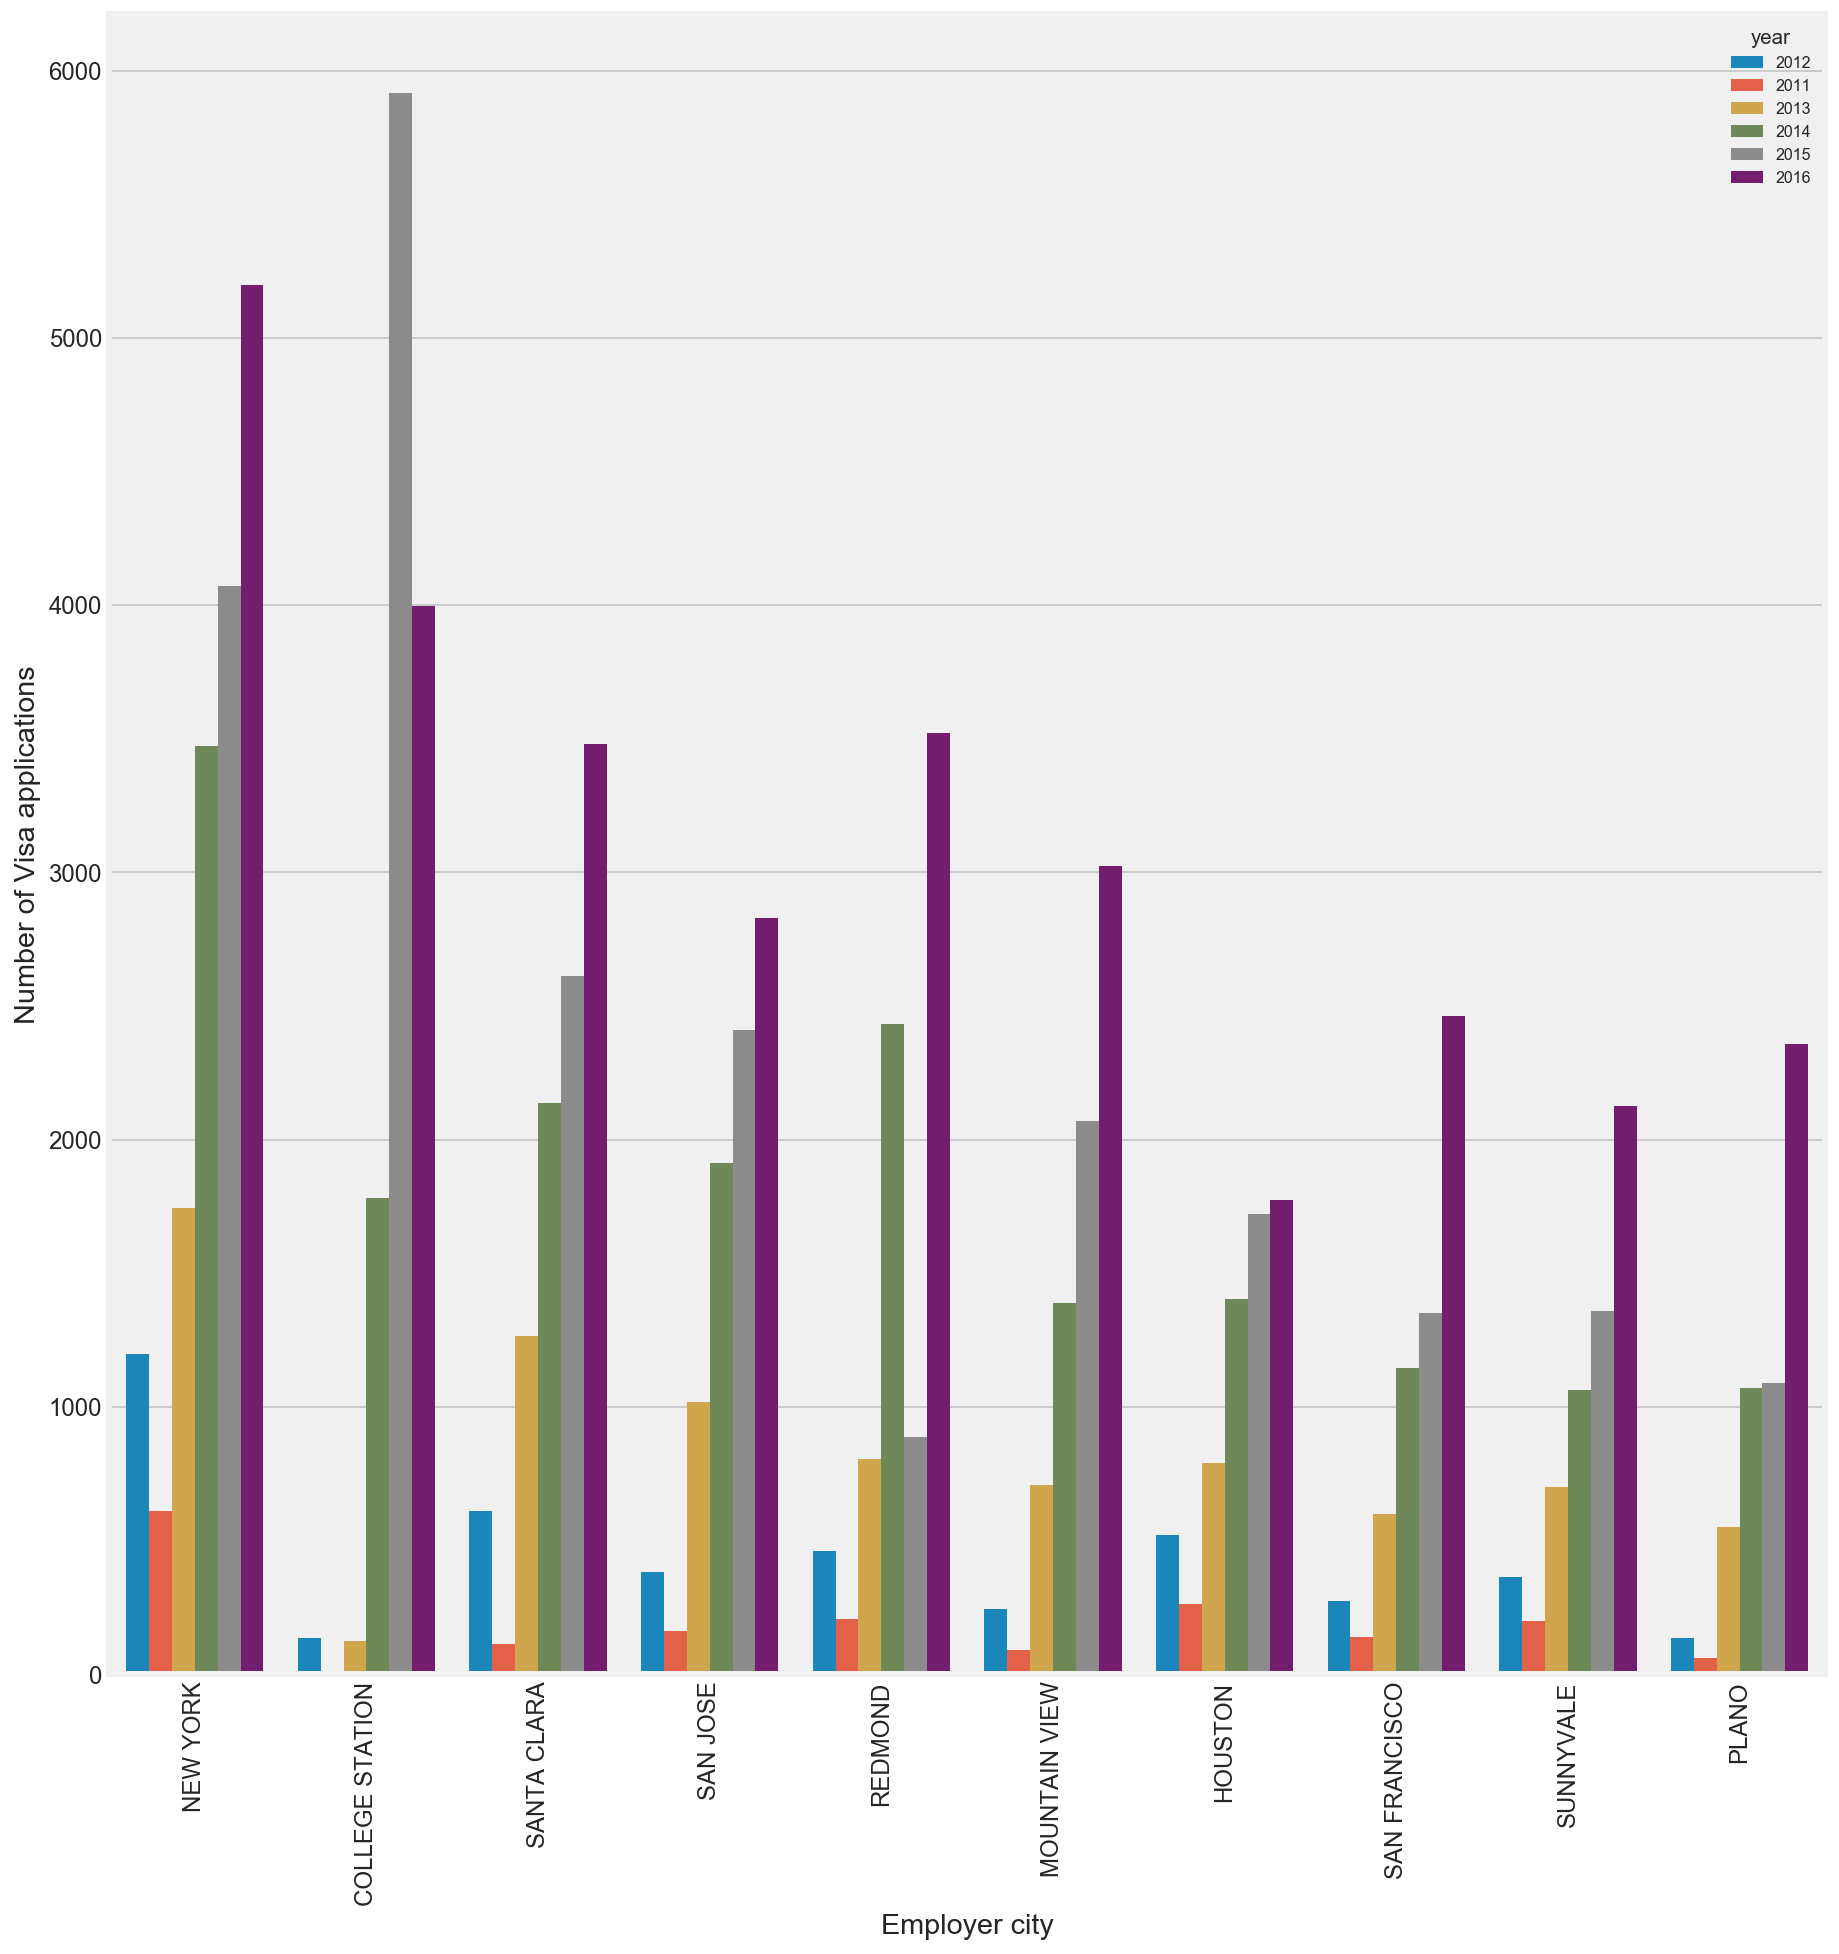

In [34]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 15.27)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})
sns.countplot(x='employer_city', hue='year', data=df, order=df.employer_city.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
ax.set(xlabel='Employer city', ylabel='Number of Visa applications')

[Text(0,0.5,'Number of Visa applications'), Text(0.5,0,'Employer name')]

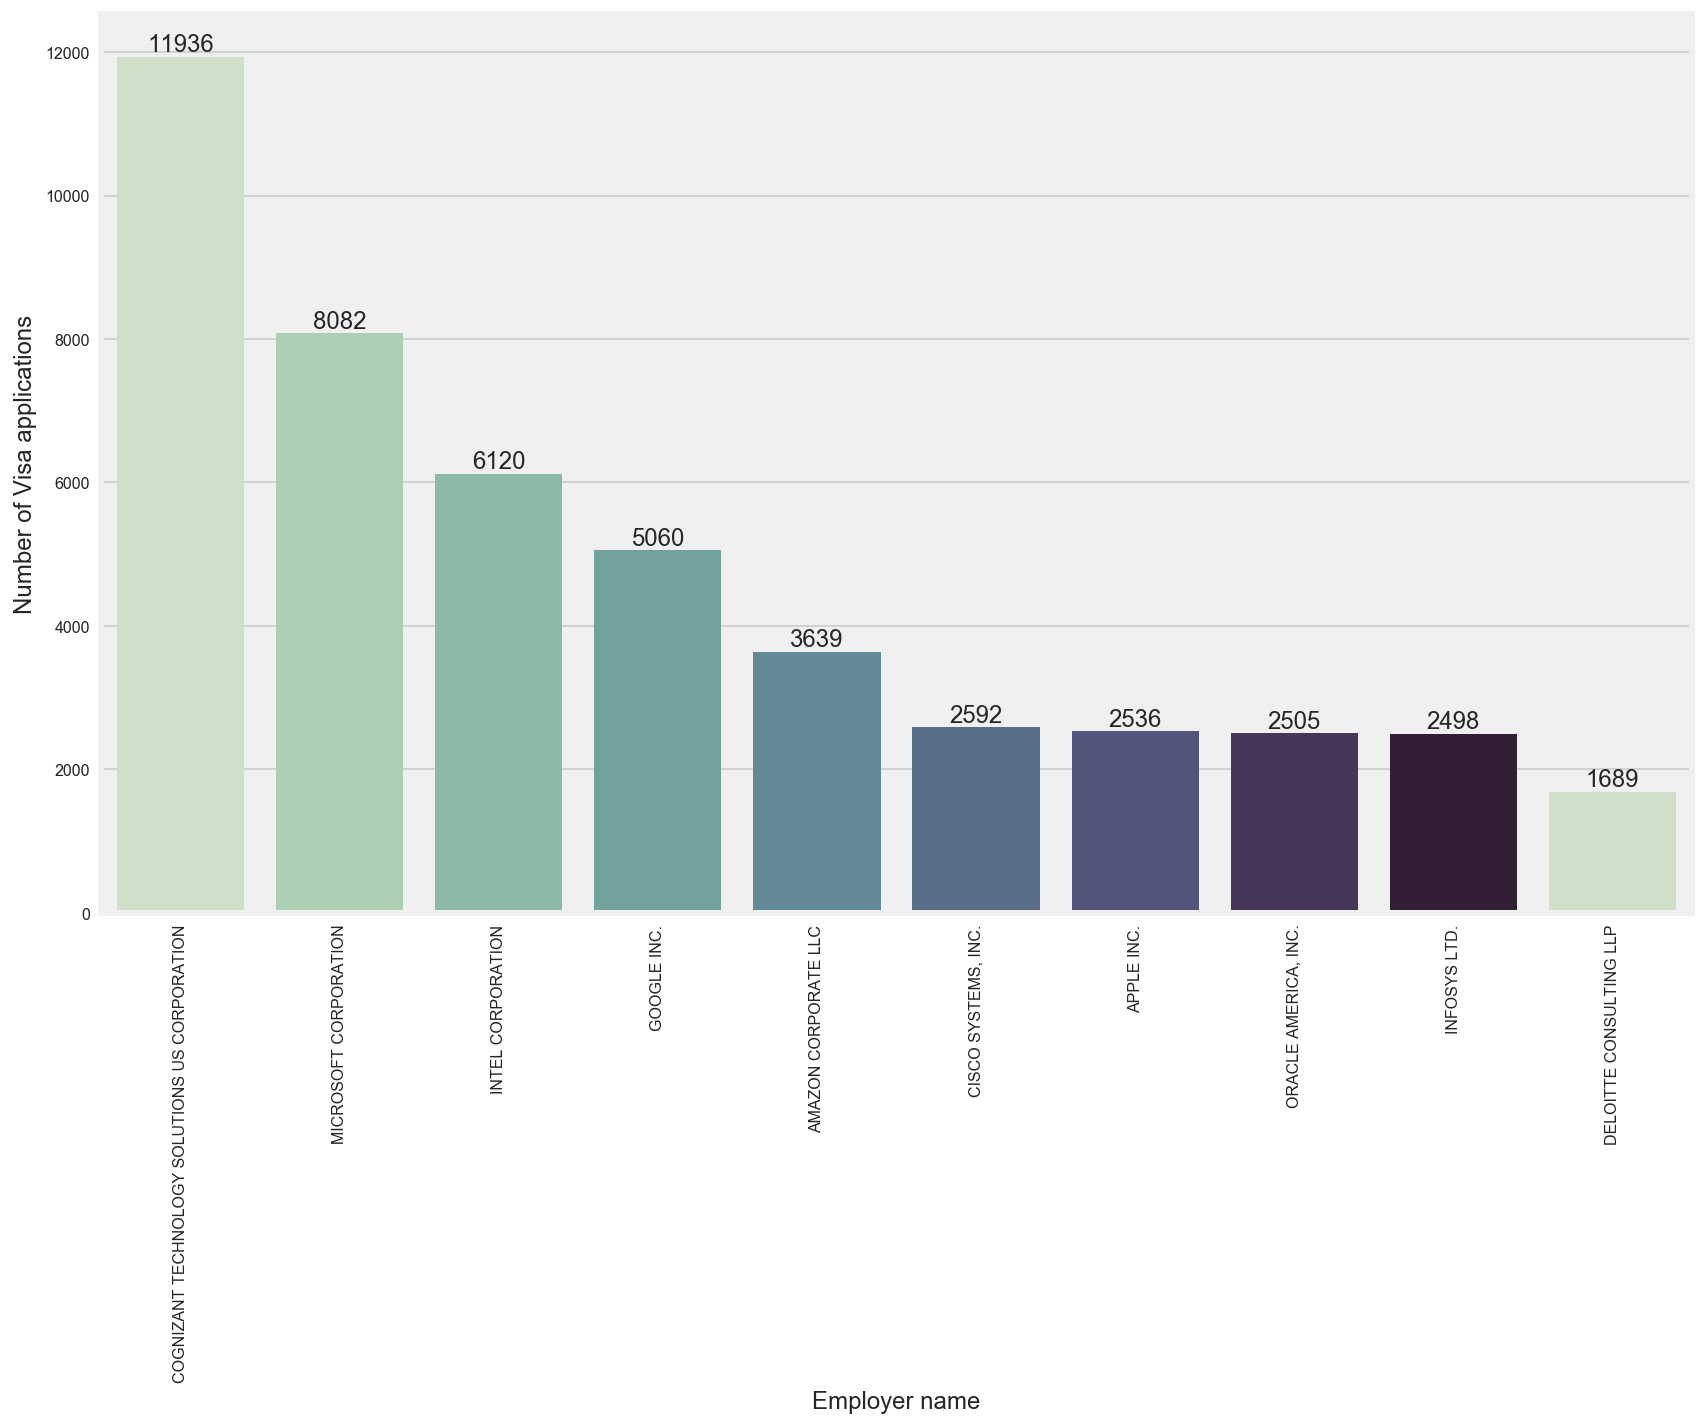

In [35]:
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.set_context(rc={"font.size":12,"axes.labelsize":13})
sns.countplot(x='employer_name', data=df, palette = sns.cubehelix_palette(9, start=.7, rot=-.75), order=df.employer_name.value_counts().iloc[:10].index)
plt.xticks(rotation=90)

#Iterating over elements in "employer_name" column and displaying counts above bars 
for i, v in df.employer_name.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.employer_name,v.unique()[1], horizontalalignment='center',verticalalignment='bottom')
    
ax.set(xlabel='Employer name', ylabel='Number of Visa applications')

### As we can see, most beneficial companies for Visa applicants are IT industry. <br>This leads to the assumption that IT sector is both most  demanding industry in United States. 

## Job title

In [36]:
df["add_these_pw_job_title_9089"]=df["add_these_pw_job_title_9089"].map(lambda x: x if type(x)!=str else x.lower())

In [37]:
df['job_info_job_title'].value_counts().head()

Software Engineer                14372
Computer Systems Analyst - V      4747
Senior Software Engineer          3801
Computer Systems Analyst - II     3416
Software Developer                2880
Name: job_info_job_title, dtype: int64

In [38]:
#Converting values to lower case
df['job_info_job_title'] = df['job_info_job_title'].str.lower()

#Splitting job titles by '-'
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.split('-').str[0]
#Splitting job titles by 'ii'
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.split('ii').str[0]
#Splitting job titles by '/'
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.split('/').str[0]
#Removing leading and ending spaces
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.strip()
#Replacing "sr." values with "senior"
df['job_info_job_title'] = df['job_info_job_title'].str.replace('sr.', 'senior')
#Replacing "NaN", "NaT" and "nan" values with np.nan
df['job_info_job_title'].replace(["NaN", 'NaT','nan'], np.nan, inplace = True)


df['job_info_job_title'].value_counts(dropna=True)[:10]

software engineer                18582
computer systems analyst         12054
senior software engineer          5802
software developer                4501
programmer analyst                3763
assistant professor               2869
software development engineer     2766
systems analyst                   2587
senior programmer analyst         1884
senior software developer         1625
Name: job_info_job_title, dtype: int64

[Text(0,0.5,'Number of Visa applications'), Text(0.5,0,'Job Title')]

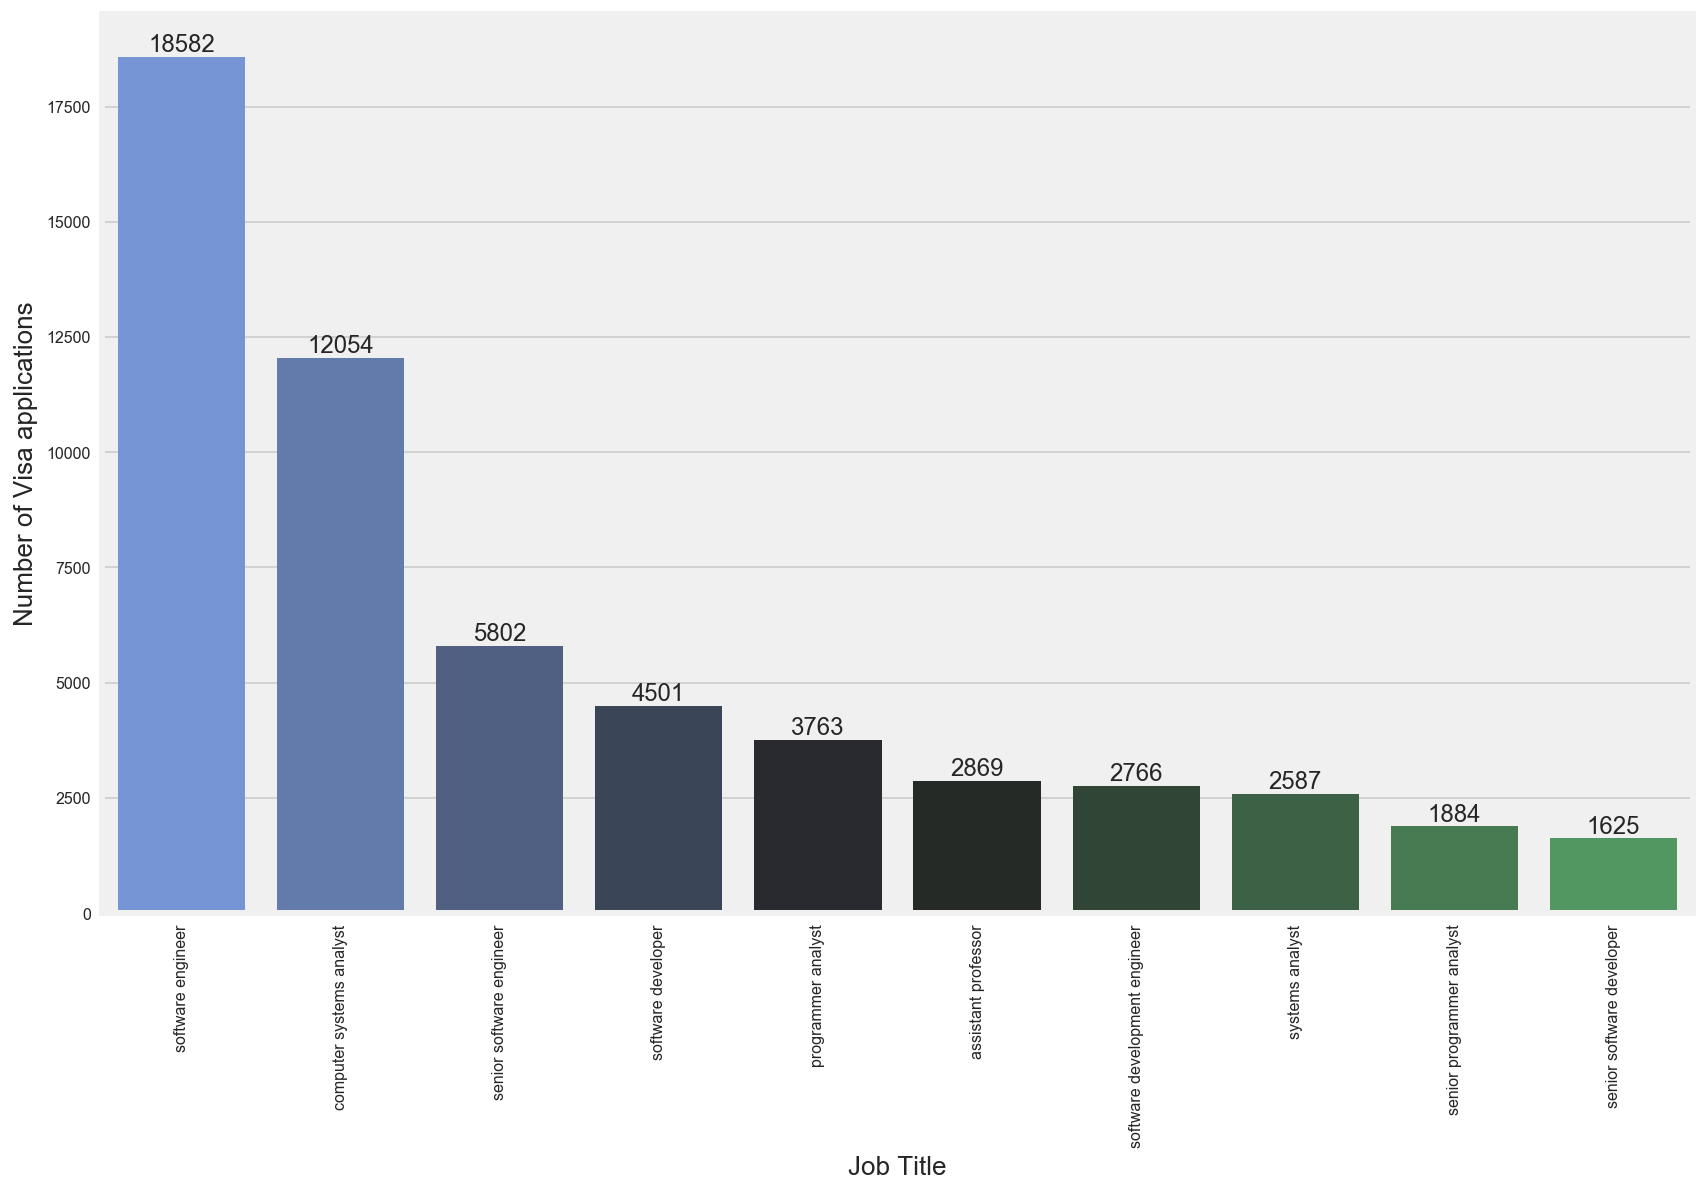

In [39]:
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
 #sns.set_context(rc={"font.size":14, "axes.labelsize":12})
sns.countplot(x='job_info_job_title',data=df, 
               palette = sns.diverging_palette(255, 133, l=60, n=10, center="dark"), 
               order=df.job_info_job_title.value_counts().iloc[:10].index)
plt.xticks(rotation=90)

#Iterating over elements in "job_info_job_title" column and displaying counts above bars 
for i, v in df.job_info_job_title.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.job_info_job_title,v.unique()[1], horizontalalignment='center',verticalalignment='bottom')

#Setting label titles    
ax.set(xlabel='Job Title', ylabel='Number of Visa applications')

[Text(0,0.5,'Number of Visa applications'), Text(0.5,0,'Visa type')]

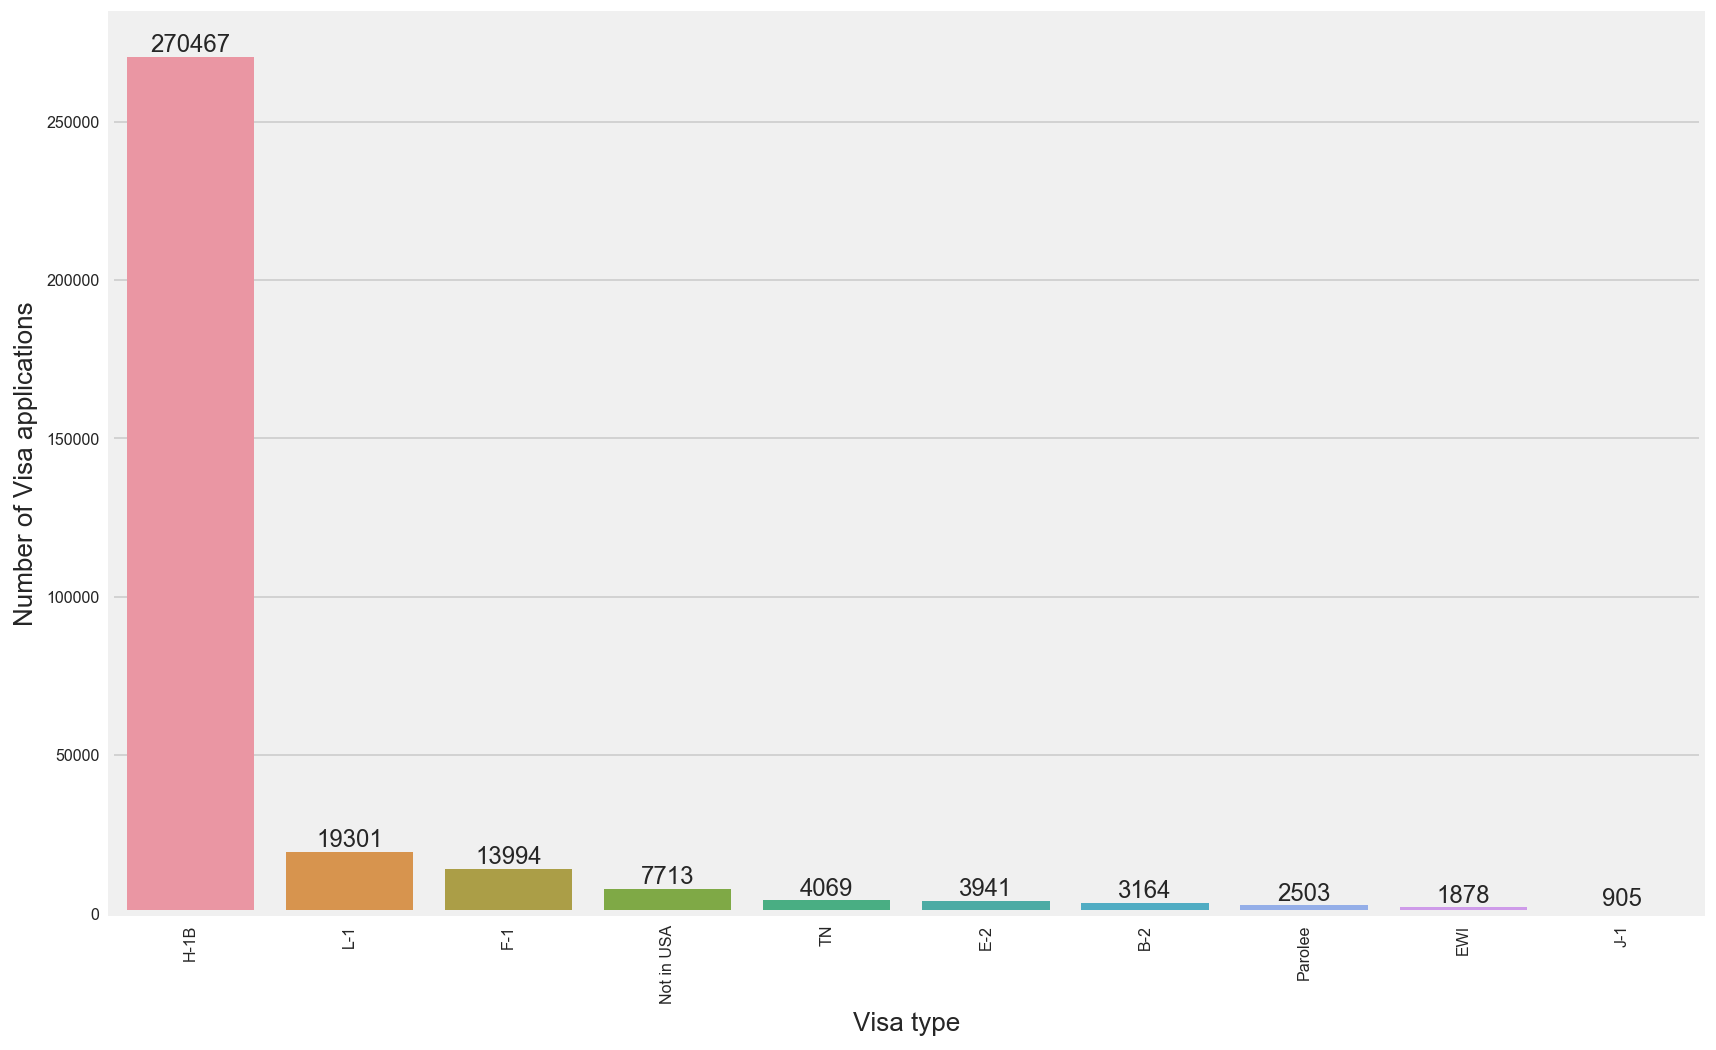

In [40]:

#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.countplot(x='class_of_admission',data=df, 
              order=df.class_of_admission.value_counts().iloc[:10].index)
plt.xticks(rotation=90)

#Iterating over elements in "class_of_admission" column and displaying counts above bars 
for i, v in df.class_of_admission.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.class_of_admission,v.unique()[1], horizontalalignment='center',verticalalignment='bottom')
    
ax.set(xlabel='Visa type', ylabel='Number of Visa applications')


### There are different class of temporary visa but H-1b is skilled working visa and people having H-1b visa have applied more permanent visa because of employee sponsorship

### Applicant's educational level at the time of submitting for the permanent residence visa process

[Text(0,0.5,'Number of Visa applications'), Text(0.5,0,'Education level')]

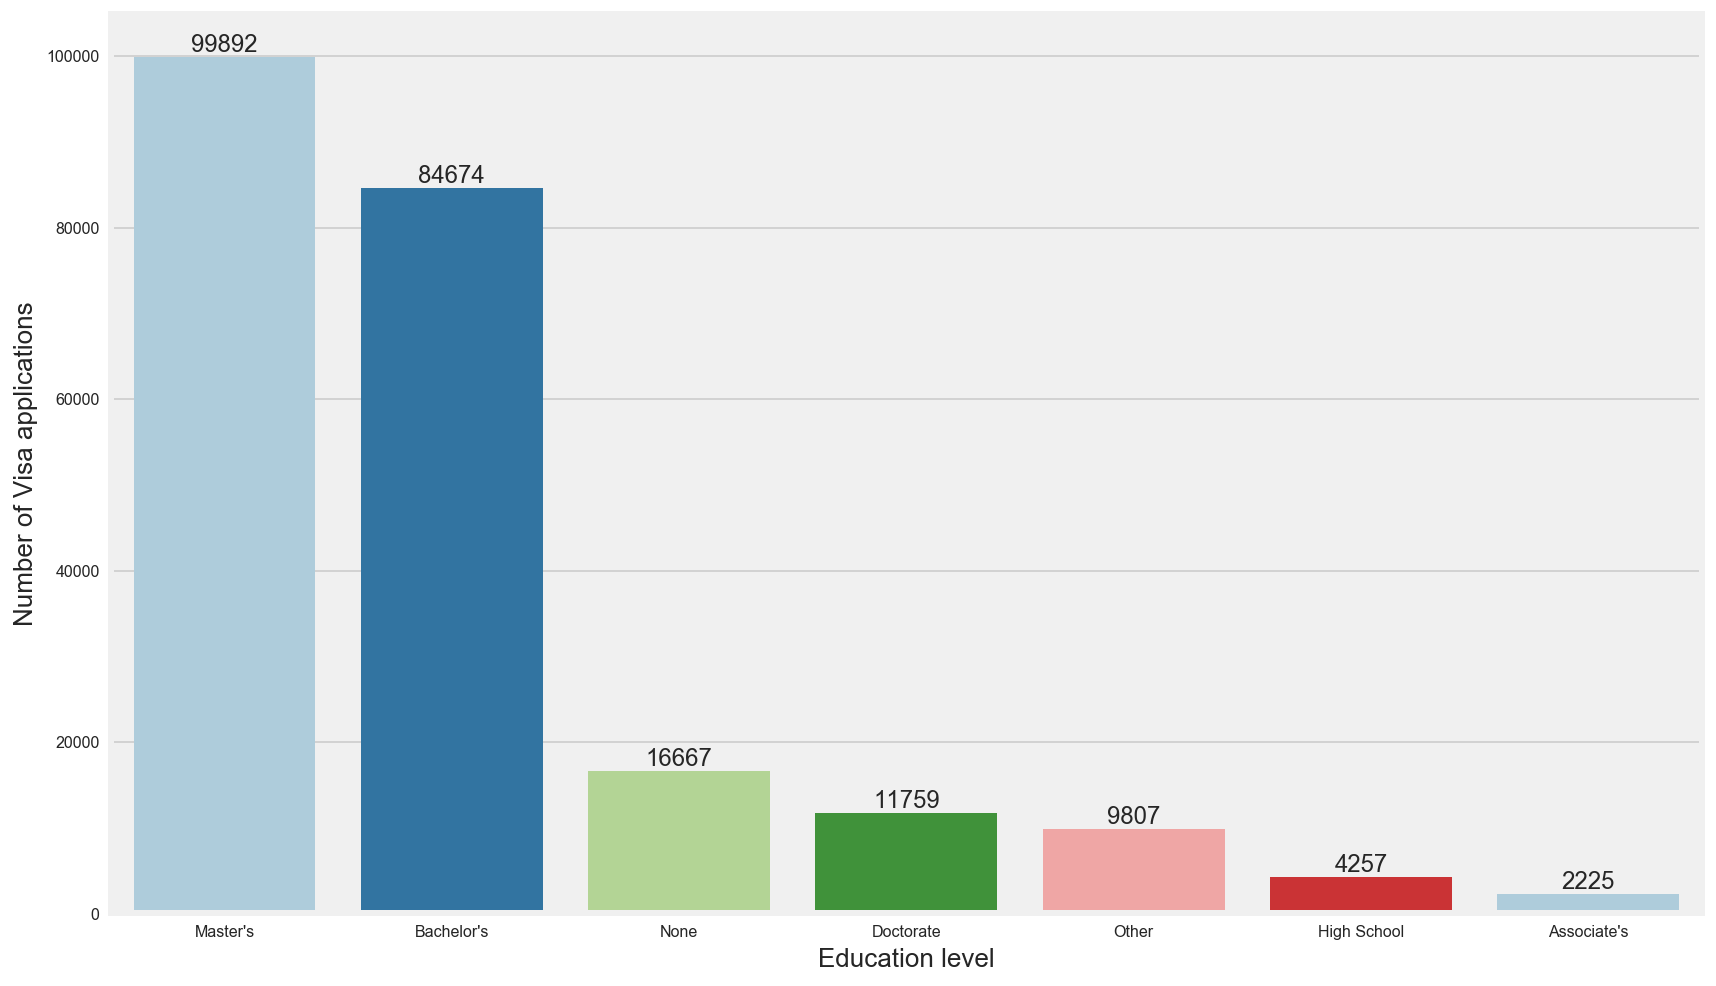

In [41]:
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
 #sns.set_context(rc={"font.size":14, "axes.labelsize":12})
sns.countplot(x='foreign_worker_info_education',data=df, 
               palette = sns.color_palette("Paired"), 
               order=df.foreign_worker_info_education.value_counts().iloc[:10].index)

#Iterating over elements in "job_info_job_title" column and displaying counts above bars 
for i, v in df.foreign_worker_info_education.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.foreign_worker_info_education,v.unique()[1], horizontalalignment='center',verticalalignment='bottom')

#Setting label titles    
ax.set(xlabel='Education level', ylabel='Number of Visa applications')

### Most of the people  work in Information technology industry have university degree and they have  skills to get in to IT industry and these people are more sponsored by the employee for permanent visa

Wall time: 1.47 s


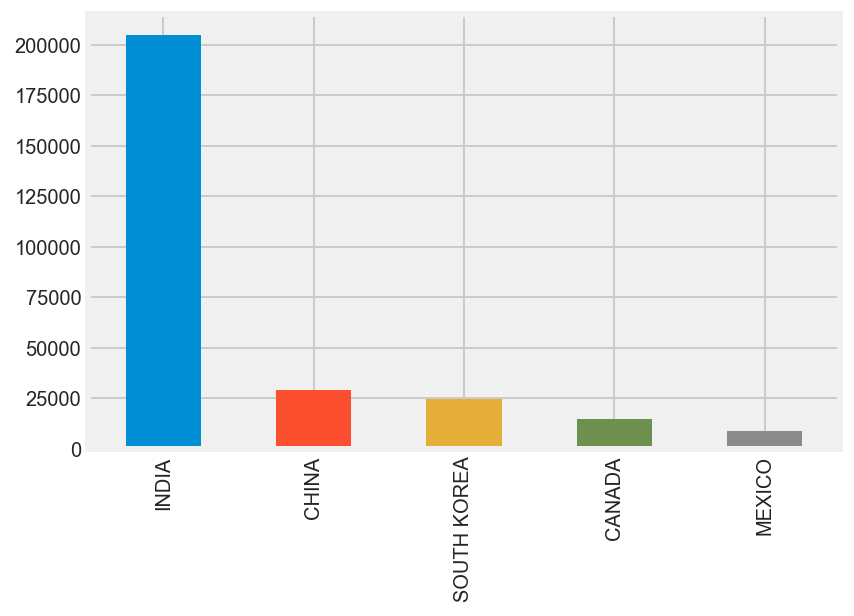

In [13]:
%%time
p_us['country_of citizenship_merged'].value_counts().head().plot(kind='bar')

### As we can see, the majority of Visa applications has been submitted by Indian citizens. They constitute to more than half of our observations, we can assume that most of them are doing IT jobs

# REMOVE COLUMNS WHICH HAVE LOT OF NAN VALUES

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356168 entries, 0 to 374353
Data columns (total 10 columns):
case_status                      356168 non-null int64
class_of_admission               356168 non-null int64
employer_city                    356168 non-null int64
employer_name                    356168 non-null int64
employer_state                   356168 non-null int64
pw_amount_9089                   356168 non-null int64
pw_soc_code                      356168 non-null int64
pw_source_name_9089              356168 non-null int64
country_of citizenship_merged    356168 non-null int64
year                             356168 non-null int64
dtypes: int64(10)
memory usage: 39.9 MB


In [43]:
%%time
#Leaving columns which have more than 330000 non-missing observations
df = df.loc[:,df.count() >= 330000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373794 entries, 0 to 374353
Data columns (total 18 columns):
case_status                      356168 non-null object
class_of_admission               335083 non-null object
employer_address_1               356131 non-null object
employer_city                    356158 non-null object
employer_name                    356160 non-null object
employer_postal_code             356135 non-null object
employer_state                   356131 non-null object
job_info_work_city               356073 non-null object
job_info_work_state              356072 non-null object
pw_amount_9089                   353965 non-null object
pw_soc_code                      355778 non-null object
pw_soc_title                     353847 non-null object
pw_source_name_9089              354081 non-null object
pw_unit_of_pay_9089              354687 non-null object
merged_case_number               356168 non-null object
country_of citizenship_merged    356113 non-null 

In [44]:
df.shape

(373794, 18)

In [45]:
df.columns

Index(['case_status', 'class_of_admission', 'employer_address_1',
       'employer_city', 'employer_name', 'employer_postal_code',
       'employer_state', 'job_info_work_city', 'job_info_work_state',
       'pw_amount_9089', 'pw_soc_code', 'pw_soc_title', 'pw_source_name_9089',
       'pw_unit_of_pay_9089', 'merged_case_number',
       'country_of citizenship_merged', 'agent_firm_name2', 'year'],
      dtype='object')

In [46]:
df.dtypes


case_status                      object
class_of_admission               object
employer_address_1               object
employer_city                    object
employer_name                    object
employer_postal_code             object
employer_state                   object
job_info_work_city               object
job_info_work_state              object
pw_amount_9089                   object
pw_soc_code                      object
pw_soc_title                     object
pw_source_name_9089              object
pw_unit_of_pay_9089              object
merged_case_number               object
country_of citizenship_merged    object
agent_firm_name2                 object
year                             object
dtype: object

In [47]:
df.year.isnull().sum()

17626

In [48]:

#Finding "nan" values in "year" column and filling them with mode
#df.loc[df['year'] == "nan",'year'] = df['year'].mode()[0]
df.year.fillna(value=df['year'].mode()[0], inplace=True) 
df['year'] = df['year'].astype(int)

In [49]:
#Assigning Labels to Case Status
df.loc[df.case_status == 'Certified/Certified-Expired', 'case_status'] = 1


In [50]:
df.loc[df.case_status == 'Denied', 'case_status'] = 0
df.case_status.value_counts()

1    330519
0     25649
Name: case_status, dtype: int64

In [51]:
df.case_status.isnull().sum()

17626

In [52]:
#Removing all nan applications
df=df[df.case_status.notnull()]

In [53]:
#Changing type from string to int

df['case_status'] = df['case_status'].astype(int)

In [54]:
df.isnull().sum()

case_status                          0
class_of_admission               21085
employer_address_1                  37
employer_city                       10
employer_name                        8
employer_postal_code                33
employer_state                      37
job_info_work_city                  95
job_info_work_state                 96
pw_amount_9089                    2203
pw_soc_code                        390
pw_soc_title                      2321
pw_source_name_9089               2087
pw_unit_of_pay_9089               1481
merged_case_number                   0
country_of citizenship_merged       55
agent_firm_name2                     0
year                                 0
dtype: int64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356168 entries, 0 to 374353
Data columns (total 18 columns):
case_status                      356168 non-null int32
class_of_admission               335083 non-null object
employer_address_1               356131 non-null object
employer_city                    356158 non-null object
employer_name                    356160 non-null object
employer_postal_code             356135 non-null object
employer_state                   356131 non-null object
job_info_work_city               356073 non-null object
job_info_work_state              356072 non-null object
pw_amount_9089                   353965 non-null object
pw_soc_code                      355778 non-null object
pw_soc_title                     353847 non-null object
pw_source_name_9089              354081 non-null object
pw_unit_of_pay_9089              354687 non-null object
merged_case_number               356168 non-null object
country_of citizenship_merged    356113 non-null o

In [56]:
#df.class_of_admission .isnull().sum()
df[df.class_of_admission.isnull()]  

,case_status,class_of_admission,employer_address_1,employer_city,employer_name,employer_postal_code,employer_state,job_info_work_city,job_info_work_state,pw_amount_9089,pw_soc_code,pw_soc_title,pw_source_name_9089,pw_unit_of_pay_9089,merged_case_number,country_of citizenship_merged,agent_firm_name2,year
14,1,NaN,4700 ANNAPOLIS RD.,BLADENSBURG,"ERNEST MAIER, INC.",20710.0,MD,Blandesburg,MD,36691.0,51-9041.00,"Extruding, Forming, Pressing, and Compacting M...",OES,yr,A-08104-41821,MEXICO,No,2011
17,1,NaN,7215 35 AVENUE,JACKSON HEIGHTS,V.H.C. USA INCD/B/A VITAMIN HOMEOPTAHY CENTER,11372.0,NY,JACKSON HEIGHTS,NY,12.06,41-2031.00,Retail Salespersons,OES,hr,A-08148-55775,CANADA,No,2011
19,1,NaN,1400 W. 171ST ST.,EAST HAZEL CREST,REFIX TRUCK & TRAILER REPAIR,60429.0,IL,East Hazel Crest,IL,10.83,51-4121.00,"Welders, Cutters, Solderers, and Brazers",OES,hr,A-08164-61023,POLAND,No,2011
26,1,NaN,P.O. BOX 3029,ROCK SPRINGS,"ROCKY MOUNTAIN CASING CREWS, INC.",82902.0,WY,Rock Springs,WY,15.82,47-5012.00,"Rotary Drill Operators, Oil and Gas",OES,hr,A-08203-71676,MEXICO,No,2012
29,0,NaN,1430 YANKEE PARK PLACE,DAYTON,"INDUS VALLEY CONSULTANTS, INC",45458.0,OH,Dayton,OH,77272.0,15-1031.00,"Computer Software Engineers, Applications",OES,yr,A-08212-74295,INDIA,No,2011
34,0,NaN,1101 OAK LANE,WINTER SPRINGS,PREMELTERS INC,32708.0,FL,WINTER SPRINGS,FL,2188.0,41-4012.00,"Sales Representatives, Wholesale and Manufactu...",OES,bi,A-08225-77723,VIETNAM,No,2011
40,1,NaN,1630 WYCOFF ROAD,WALL,GARDEN STATE PRECAST,7719.0,NC,WALL,NJ,17.33,37-2011.00,"Janitors and Cleaners, Except Maids and Housek...",OES,hr,A-08246-83350,ECUADOR,No,2011
42,0,NaN,10130-B COLVIN RUN ROAD,GREAT FALLS,"ANA VISAGE, LTD",22066.0,VA,Great Falls,VA,41517.0,43-6011.00,Executive Secretaries and Administrative Assis...,OES,yr,A-08254-85569,IRAN,No,2011
44,0,NaN,73-15 MAIN STREET,FLUSHING,AIRPLUS CONTRACTING INC.,11367.0,NY,FLUSHING,NY,21.86,47-2031.00,Carpenters,OES,hr,A-08259-87626,PAKISTAN,No,2012
56,0,NaN,351 KILORIN ROAD,WATERTOWN,B & F CONSTRUCTION CO.,6795.0,CT,WATERTOWN,CT,NaN,47-2031.00,Carpenters,OES,NaN,A-08284-95050,JAMAICA,No,2011


In [57]:
df.isnull().sum()

case_status                          0
class_of_admission               21085
employer_address_1                  37
employer_city                       10
employer_name                        8
employer_postal_code                33
employer_state                      37
job_info_work_city                  95
job_info_work_state                 96
pw_amount_9089                    2203
pw_soc_code                        390
pw_soc_title                      2321
pw_source_name_9089               2087
pw_unit_of_pay_9089               1481
merged_case_number                   0
country_of citizenship_merged       55
agent_firm_name2                     0
year                                 0
dtype: int64

## statistics-imputation_missing_data<br>
I used mode as my imputation parameter to fill missing values because it selects highest occurence and fill it .


In [58]:

df['class_of_admission']=df['class_of_admission'].fillna((df['class_of_admission'].mode()[0]))
df['employer_address_1']=df['employer_address_1'].fillna((df['employer_address_1'].mode()[0]))
df['employer_city']=df['employer_city'].fillna((df['employer_city'].mode()[0]))
df['employer_state']=df['employer_state'].fillna((df['employer_state'].mode()[0]))

In [59]:
df.isnull().sum()

case_status                         0
class_of_admission                  0
employer_address_1                  0
employer_city                       0
employer_name                       8
employer_postal_code               33
employer_state                      0
job_info_work_city                 95
job_info_work_state                96
pw_amount_9089                   2203
pw_soc_code                       390
pw_soc_title                     2321
pw_source_name_9089              2087
pw_unit_of_pay_9089              1481
merged_case_number                  0
country_of citizenship_merged      55
agent_firm_name2                    0
year                                0
dtype: int64

### PW

In [60]:
df['pw_soc_code'] = df['pw_soc_code'].str.replace('.','')
df['pw_soc_code'] = df['pw_soc_code'].str.replace('-','')
df['pw_soc_code'] = df['pw_soc_code'].astype(str).str[0:6]
df['pw_soc_code'].value_counts()

#Finding "nan" values in "pw_soc_code" column and filling them with mode
df.loc[df['pw_soc_code'] == "nan",'pw_soc_code'] = df['pw_soc_code'].mode()[0]

#Finding "None" values in "pw_soc_code" column and filling them with mode
df.loc[df['pw_soc_code'] == "None",'pw_soc_code'] = df['pw_soc_code'].mode()[0]

#Changing type from string to int
df['pw_soc_code'] = df['pw_soc_code'].astype(int)


In [61]:
df.pw_unit_of_pay_9089.value_counts()

Year         328256
yr            18450
Hour           6961
hr              677
Week            175
Month           114
Bi-Weekly        22
wk               20
mth               7
bi                5
Name: pw_unit_of_pay_9089, dtype: int64

In [62]:
#Replacing commas with whitespace character
df['pw_amount_9089'] = df['pw_amount_9089'].str.replace(",","") 

# 250  working days in a year
# each day 8 hours of work-(8*250)
#12 months a year
#25  bi-weekly in a year
# 50 weeks in a year


for unit in df.pw_unit_of_pay_9089.unique():
    if unit == "hr" or unit == "Hour":
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 8 * 250)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year") 
    elif unit == "wk" or unit == "Week":
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 50)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "mth" or unit == "Month":
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 12)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "bi" or unit == "Bi-Weekly":  
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 25)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit =="yr":
         df.loc[df['pw_unit_of_pay_9089'] == unit ,'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    else:
        continue
        
#Filling missing values with median 
df['pw_amount_9089']= df['pw_amount_9089'].fillna((df['pw_amount_9089'].median()))

#Changing format from string to float
df['pw_amount_9089'] = df.pw_amount_9089.astype(float)



In [63]:
#Displaying 5 first values
df[['pw_amount_9089','pw_unit_of_pay_9089']].head()

,pw_amount_9089,pw_unit_of_pay_9089
0,75629.0,Year
1,37024.0,Year
2,47923.0,Year
3,21940.0,Year
4,94890.0,Year


In [64]:
#Changing type from string to int
df['pw_soc_code'] = df['pw_soc_code'].astype(int)

In [65]:

df['pw_soc_code'] = df['pw_soc_code'].astype(str).str[0:6]
#Finding "nan" values in "pw_soc_code" column and filling them with mode
df.loc[df['pw_soc_code'] == "nan",'pw_soc_code'] = df['pw_soc_code'].mode()[0]

#Finding "None" values in "pw_soc_code" column and filling them with mode
df.loc[df['pw_soc_code'] == "None",'pw_soc_code'] = df['pw_soc_code'].mode()[0]

df['pw_soc_code'].head()




0    151031
1    474041
2    172051
3    434071
4    419031
Name: pw_soc_code, dtype: object

In [66]:
df.isnull().sum()

case_status                         0
class_of_admission                  0
employer_address_1                  0
employer_city                       0
employer_name                       8
employer_postal_code               33
employer_state                      0
job_info_work_city                 95
job_info_work_state                96
pw_amount_9089                      0
pw_soc_code                         0
pw_soc_title                     2321
pw_source_name_9089              2087
pw_unit_of_pay_9089              1481
merged_case_number                  0
country_of citizenship_merged      55
agent_firm_name2                    0
year                                0
dtype: int64

In [67]:
df.drop(['agent_firm_name2','merged_case_number','job_info_work_state','pw_soc_title','job_info_work_city','employer_postal_code','pw_unit_of_pay_9089'],axis=1,inplace=True)

In [68]:
df.isnull().sum()

case_status                         0
class_of_admission                  0
employer_address_1                  0
employer_city                       0
employer_name                       8
employer_state                      0
pw_amount_9089                      0
pw_soc_code                         0
pw_source_name_9089              2087
country_of citizenship_merged      55
year                                0
dtype: int64

In [69]:
df.pw_source_name_9089.value_counts()

OES                   325046
Other                  24791
CBA                     3638
Employer Conducted       513
SCA                       69
DBA                       24
Name: pw_source_name_9089, dtype: int64

In [70]:
df['country_of citizenship_merged'].fillna(value='not available', inplace=True) 
df['employer_name'].fillna(value='not available', inplace=True) 
df.pw_source_name_9089.fillna(value='Other', inplace=True) 

In [71]:
df.isnull().sum()

case_status                      0
class_of_admission               0
employer_address_1               0
employer_city                    0
employer_name                    0
employer_state                   0
pw_amount_9089                   0
pw_soc_code                      0
pw_source_name_9089              0
country_of citizenship_merged    0
year                             0
dtype: int64

In [72]:
df.drop(['employer_address_1'],axis=1,inplace=True)

In [73]:
d=df

In [74]:

d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356168 entries, 0 to 374353
Data columns (total 10 columns):
case_status                      356168 non-null int32
class_of_admission               356168 non-null object
employer_city                    356168 non-null object
employer_name                    356168 non-null object
employer_state                   356168 non-null object
pw_amount_9089                   356168 non-null float64
pw_soc_code                      356168 non-null object
pw_source_name_9089              356168 non-null object
country_of citizenship_merged    356168 non-null object
year                             356168 non-null int32
dtypes: float64(1), int32(2), object(7)
memory usage: 37.2+ MB


# Converting the categorical variable into numeric 


In [75]:
%%time

from sklearn.preprocessing import LabelEncoder
categorical_variables = {}

#Creating categories denoted by integers from column values
for col in df.columns:
    cat_var_name = "cat_"+ col
    cat_var_name = LabelEncoder()
    cat_var_name.fit(d[col])
    d[col] = cat_var_name.transform(d[col])
    categorical_variables[col] = cat_var_name

d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356168 entries, 0 to 374353
Data columns (total 10 columns):
case_status                      356168 non-null int64
class_of_admission               356168 non-null int64
employer_city                    356168 non-null int64
employer_name                    356168 non-null int64
employer_state                   356168 non-null int64
pw_amount_9089                   356168 non-null int64
pw_soc_code                      356168 non-null int64
pw_source_name_9089              356168 non-null int64
country_of citizenship_merged    356168 non-null int64
year                             356168 non-null int64
dtypes: int64(10)
memory usage: 39.9 MB
Wall time: 6.88 s


In [76]:
d.head()

,case_status,class_of_admission,employer_city,employer_name,employer_state,pw_amount_9089,pw_soc_code,pw_source_name_9089,country_of citizenship_merged,year
0,1,28,3506,43093,76,10352,76,3,7,1
1,0,5,749,47833,76,2846,592,3,142,0
2,1,19,1897,54367,99,5055,122,3,79,0
3,1,5,1694,18799,76,786,511,3,163,0
4,1,31,53,2343,76,14487,493,3,34,1


sns.heatmap(d.corr())
plt.show()

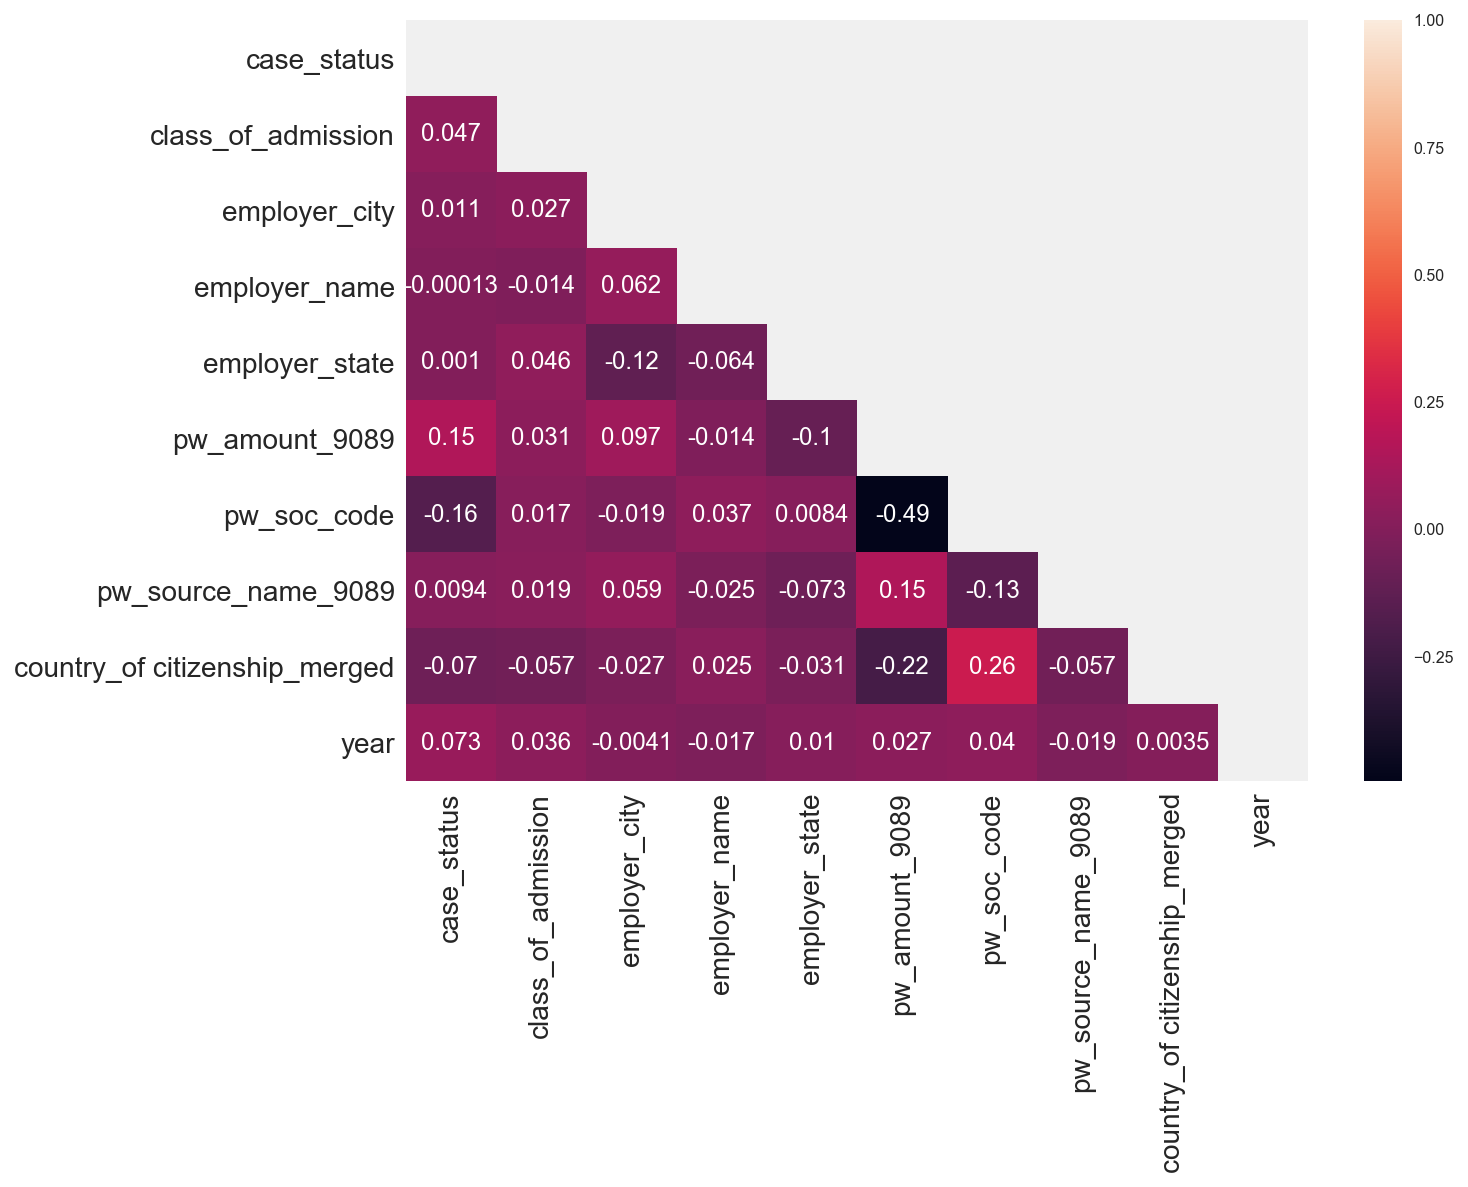

Wall time: 724 ms


In [77]:
%%time
mean_corr = d.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax,annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [78]:
d.case_status.value_counts()

1    330519
0     25649
Name: case_status, dtype: int64

In [79]:
d.shape

(356168, 10)

### variable of interest(Target variable)
Case status

In [80]:
#Dividing our final dataset into features(explanatory variables) and labels(target variable)
X = d.loc[:, d.columns != 'case_status']
y = d.case_status

In [81]:
X.shape

(356168, 9)

In [82]:
y.shape

(356168,)

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25)
print('....................')
print('train shape')
print('X',X_train.shape)
print('y',y_train.shape)
print('....................')
print('....................')
print('test shape')
print('X',X_test.shape)

print('y',y_test.shape)
print('....................')


....................
train shape
X (267126, 9)
y (267126,)
....................
....................
test shape
X (89042, 9)
y (89042,)
....................


### I got  inbalance class for my target variable with more than '92 percent on class 1 'and 'about 7 percent on class 0'
* so I used SMOTE to balance my training data set and test it on unbalanced real data set

In [84]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

c:\users\karthik\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


## BASELINE SCORE

In [85]:
y_train.value_counts()/len(y_train)

1    0.928116
0    0.071884
Name: case_status, dtype: float64

In [86]:
np.mean(y_train_res)

0.5

## Decision Tree

### I have binary class catogorical Target variable , on which I can do classification .<br>
Based on large data set and with 10 features <br>
. On which I can work all my tree based classification models like decision tree , random forest and gradient boosting algorithm


In [130]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

http://chrisstrelioff.ws/sandbox/2015/06/25/decision_trees_in_python_again_cross_validation.html
http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/

## implementation:
I used grid search to get my best parameter which I assigned in grid param and cross validation set to 4 .
Fitted the model and exaimed 

In [131]:
%%time
# grid search for best combination of C and penalty
from sklearn.grid_search import GridSearchCV

dtc_params = {
    
    'max_depth': [15,20,25,30],
     'max_features': [2,3,4],
     'random_state': [123],
     
}
grid_dt = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=4)


Wall time: 0 ns


In [132]:
%%time
grid_dt.fit(x_train_res, y_train_res)

Wall time: 1min 18s


GridSearchCV(cv=4, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [15, 20, 25, 30], 'max_features': [2, 3, 4], 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [133]:
%%time
# examine the best 
print(grid_dt.best_score_)
print(grid_dt.best_params_)
dtc_best = grid_dt.best_estimator_

0.9277359190719737
{'max_depth': 30, 'max_features': 4, 'random_state': 123}


In [134]:
y_pred_dt = grid_dt.predict(X_test)
y_pred_dt 

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [135]:
confusion_dt = confusion_matrix(y_test,y_pred_dt)
confusion_dt

array([[ 2875,  3572],
       [ 6009, 76586]], dtype=int64)

In [136]:
y_pp_dt = grid_dt.predict_proba(X_test)

In [139]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dt))
# calculate testing accuracy
from sklearn import metrics
print('accuracy',metrics.accuracy_score(y_test, y_pred_dt))

             precision    recall  f1-score   support

          0       0.32      0.45      0.38      6447
          1       0.96      0.93      0.94     82595

avg / total       0.91      0.89      0.90     89042

accuracy 0.8923990925630602


In [140]:
grid_reg_coefs_dt = pd.DataFrame({
        'feature':X.columns,
        'importance':dtc_best.feature_importances_
    })

grid_reg_coefs_dt.sort_values('importance', inplace=True, ascending=False)
grid_reg_coefs_dt

,feature,importance
8,year,0.300965
4,pw_amount_9089,0.164541
5,pw_soc_code,0.154721
7,country_of citizenship_merged,0.069902
2,employer_name,0.067717
3,employer_state,0.067075
0,class_of_admission,0.064976
6,pw_source_name_9089,0.055347
1,employer_city,0.054757


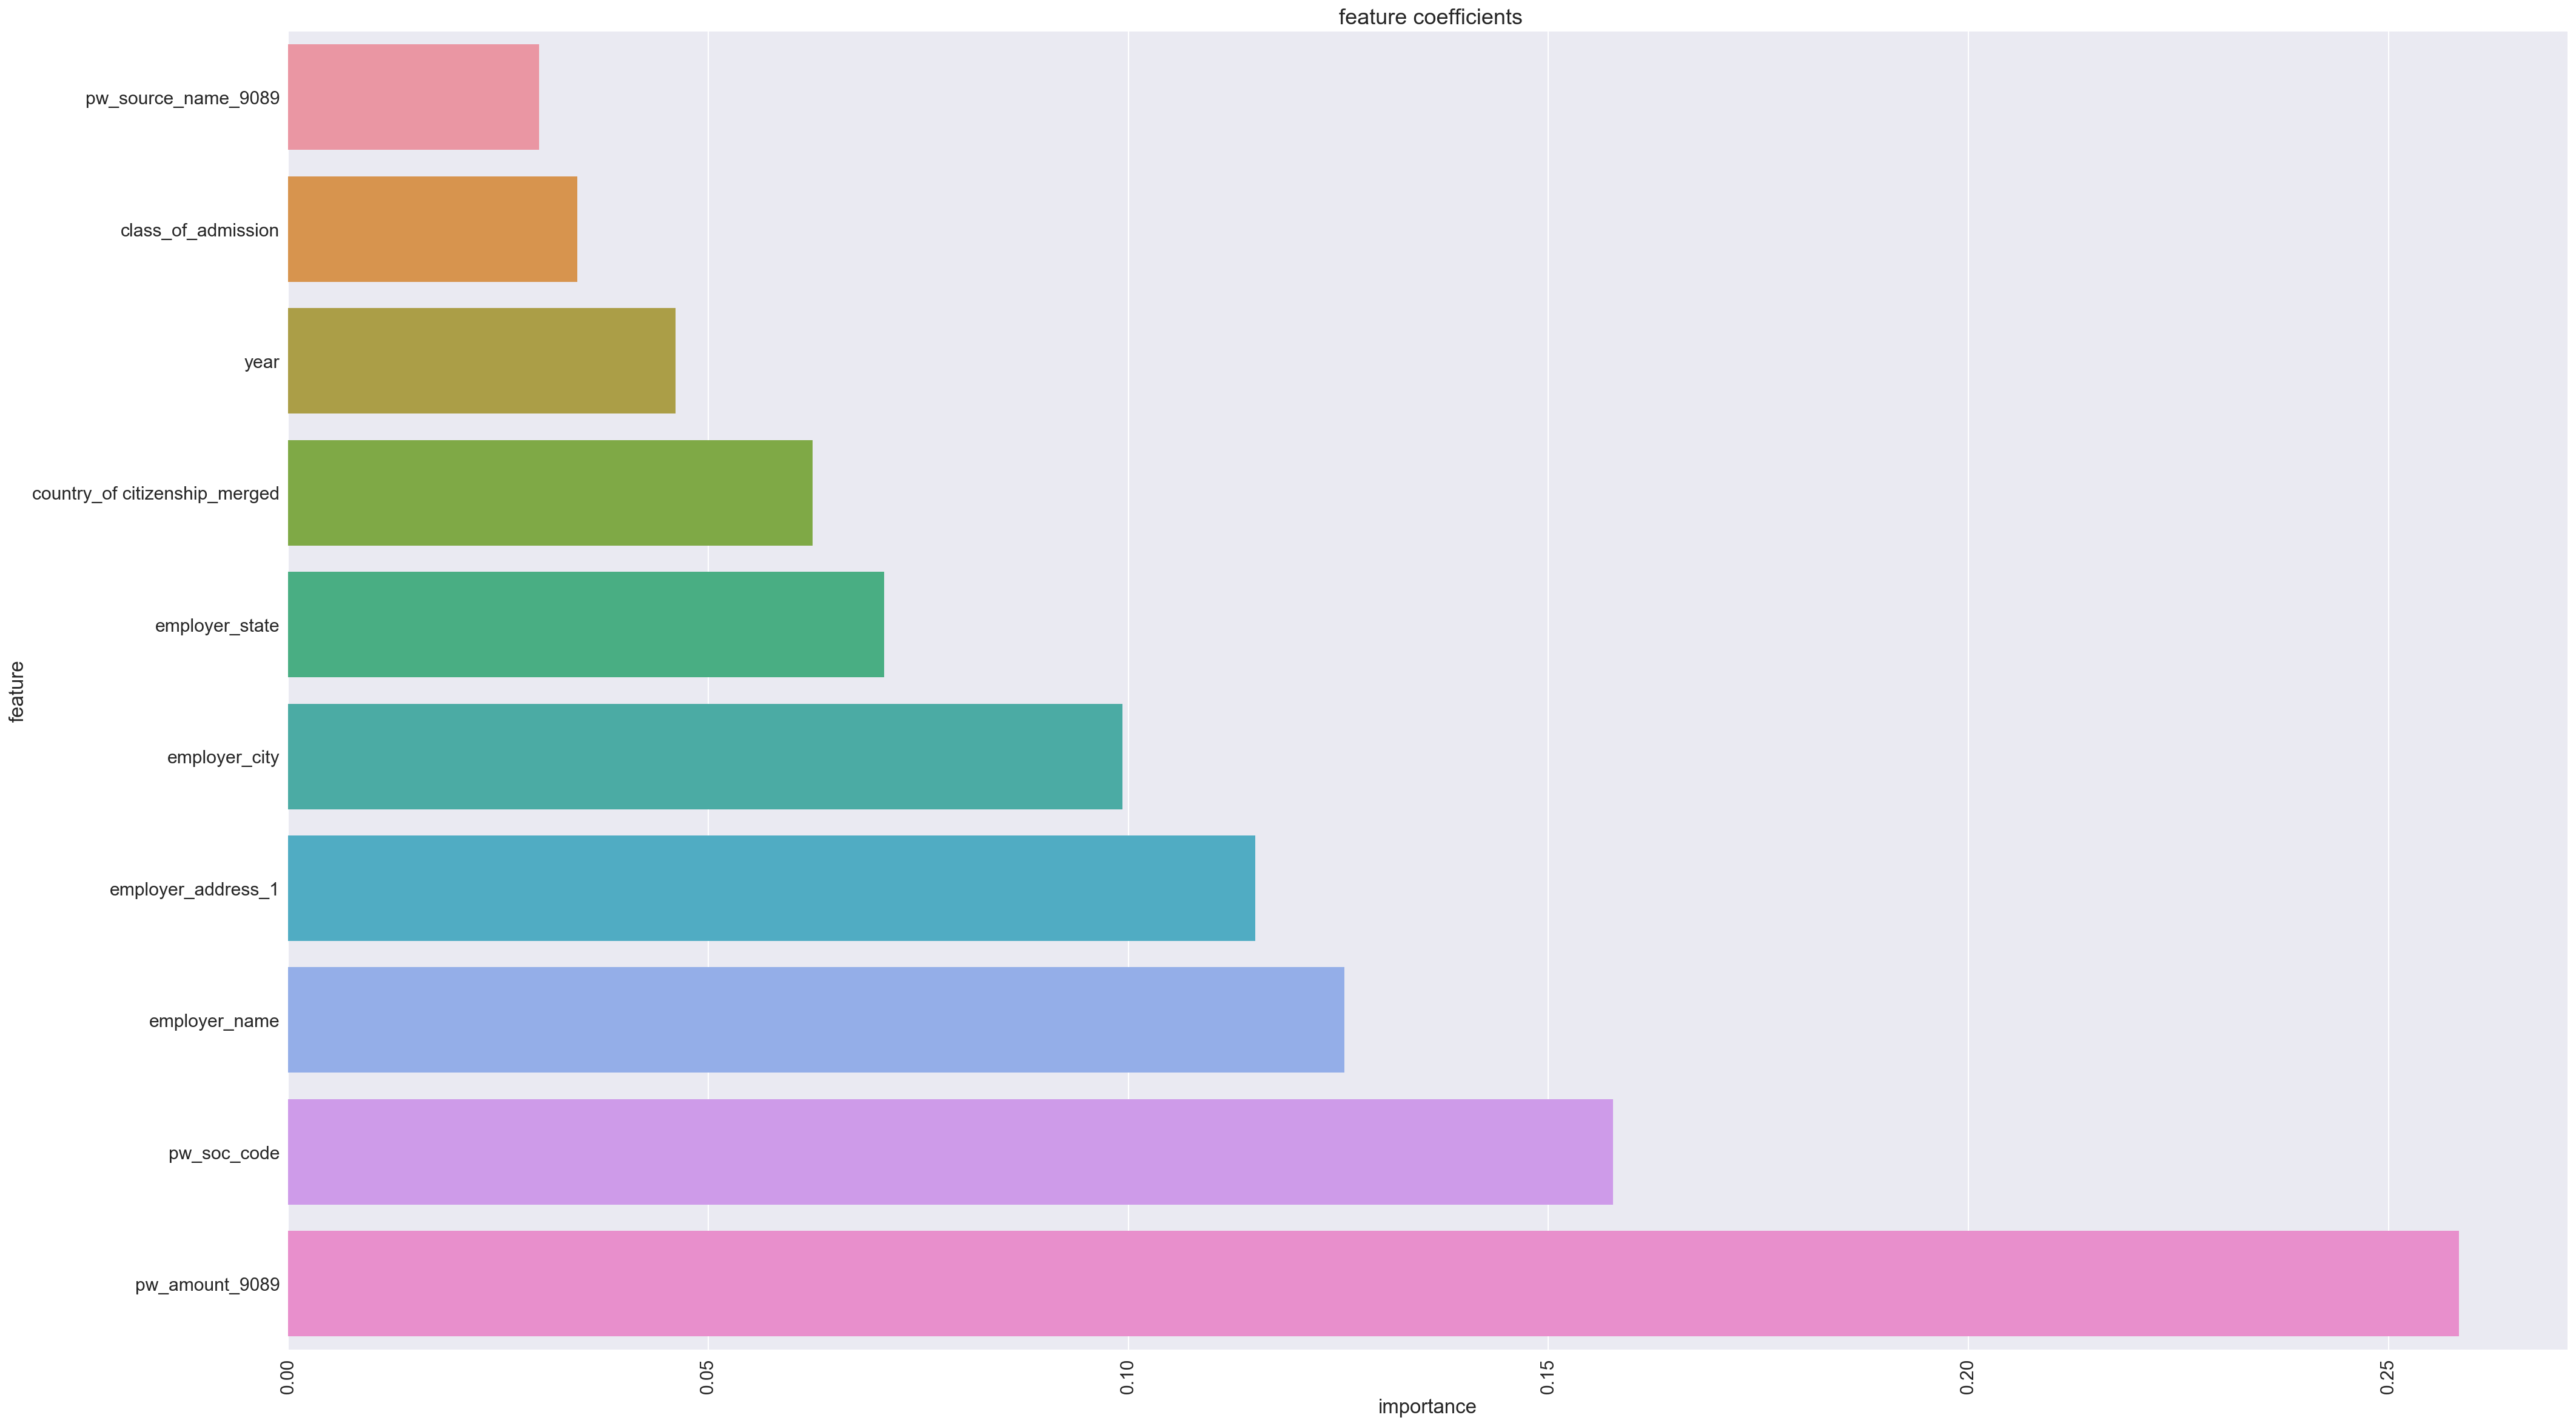

In [133]:
plt.figure(figsize=(30,20))
sns.set(font_scale=1.5)
sns.barplot(x='importance',y='feature',data=grid_reg_coefs_dt.sort_values('importance'))
plt.title(' feature coefficients')
plt.xticks(rotation=90)
plt.show()

In [137]:
Y_pp_dt = pd.DataFrame(y_pp_dt, columns=['class_0_pp','class_1_pp'])
Y_pp_dt.head()

,class_0_pp,class_1_pp
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


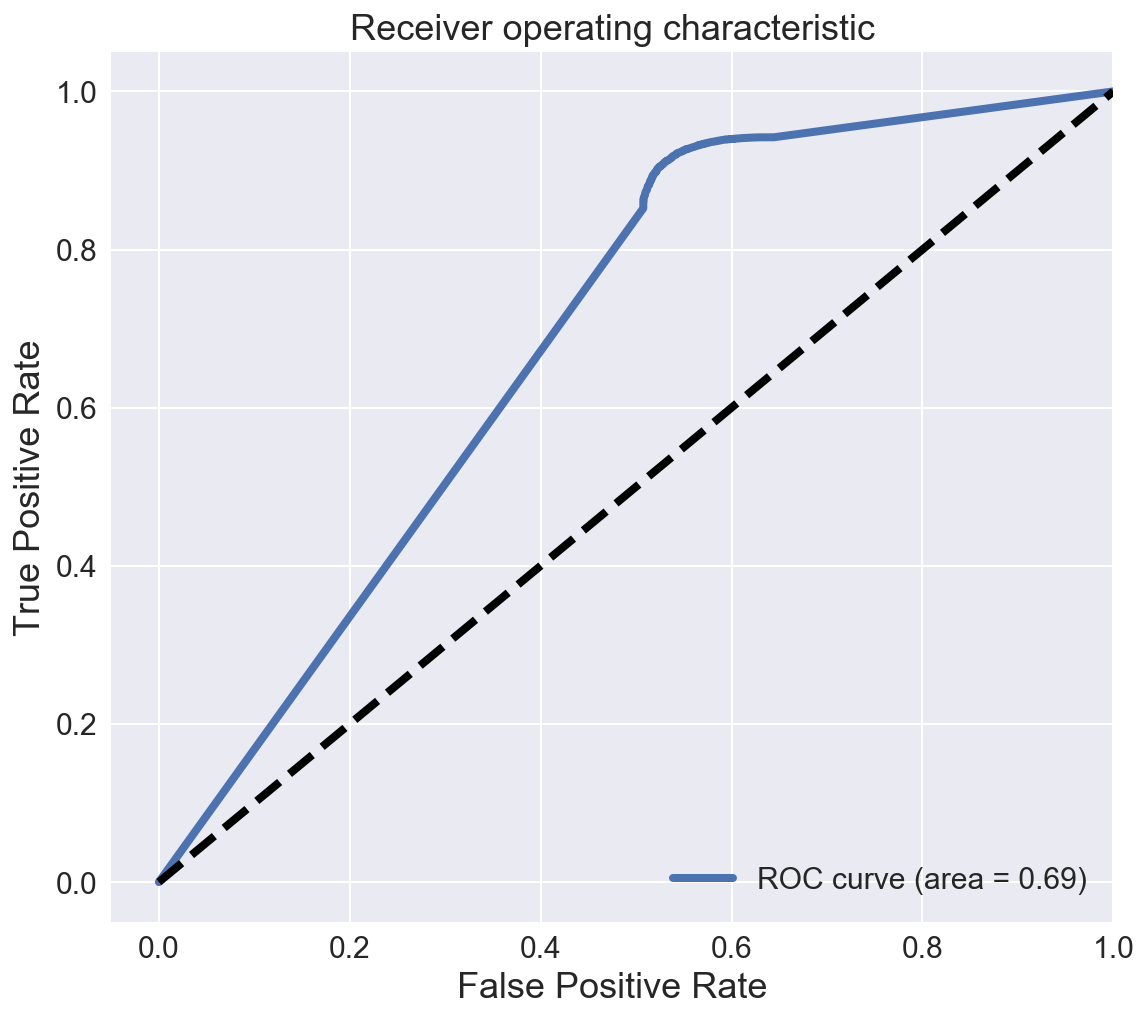

In [138]:
from sklearn.metrics import roc_curve, auc
# For class 1, find the area under the curve
fpr, tpr, _ = roc_curve(y_test, Y_pp_dt.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Random forest

In [101]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


%matplotlib inline


In [102]:
rfc=RandomForestClassifier(random_state=42)

In [103]:
param_grid = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4],
     'random_state': [123],
     'n_jobs': [-1]
    }
    

In [104]:
%%time
grid_rf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid_rf.fit(x_train_res, y_train_res)

Wall time: 1h 41min 39s


In [106]:
# examine the best model
print(grid_rf.best_score_)
print(grid_rf.best_ 
rf_best = grid_rf.best_estimator_

0.9583098046175441
{'max_depth': 30, 'max_features': 3, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 123}


In [107]:
y_pred_rf= grid_rf.predict(X_test)
y_pred_rf 

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [108]:
confusion_rf = confusion_matrix(y_test,y_pred_rf)
confusion_rf

array([[ 2464,  3983],
       [ 2066, 80529]], dtype=int64)

In [121]:
y_pp_rf = grid_rf.predict_proba(X_test)

In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))
# calculate testing accuracy
from sklearn import metrics
print('accuracy',metrics.accuracy_score(y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.54      0.38      0.45      6447
          1       0.95      0.97      0.96     82595

avg / total       0.92      0.93      0.93     89042

accuracy 0.9320657667168303


In [110]:
grid_reg_coefs_rf = pd.DataFrame({
        'feature':X.columns,
        'importance':rf_best.feature_importances_
    })

grid_reg_coefs_rf.sort_values('importance', inplace=True, ascending=False)
grid_reg_coefs_rf

,feature,importance
8,year,0.249651
5,pw_soc_code,0.159993
7,country_of citizenship_merged,0.138720
4,pw_amount_9089,0.134595
3,employer_state,0.081929
2,employer_name,0.069043
0,class_of_admission,0.064530
1,employer_city,0.059775
6,pw_source_name_9089,0.041765


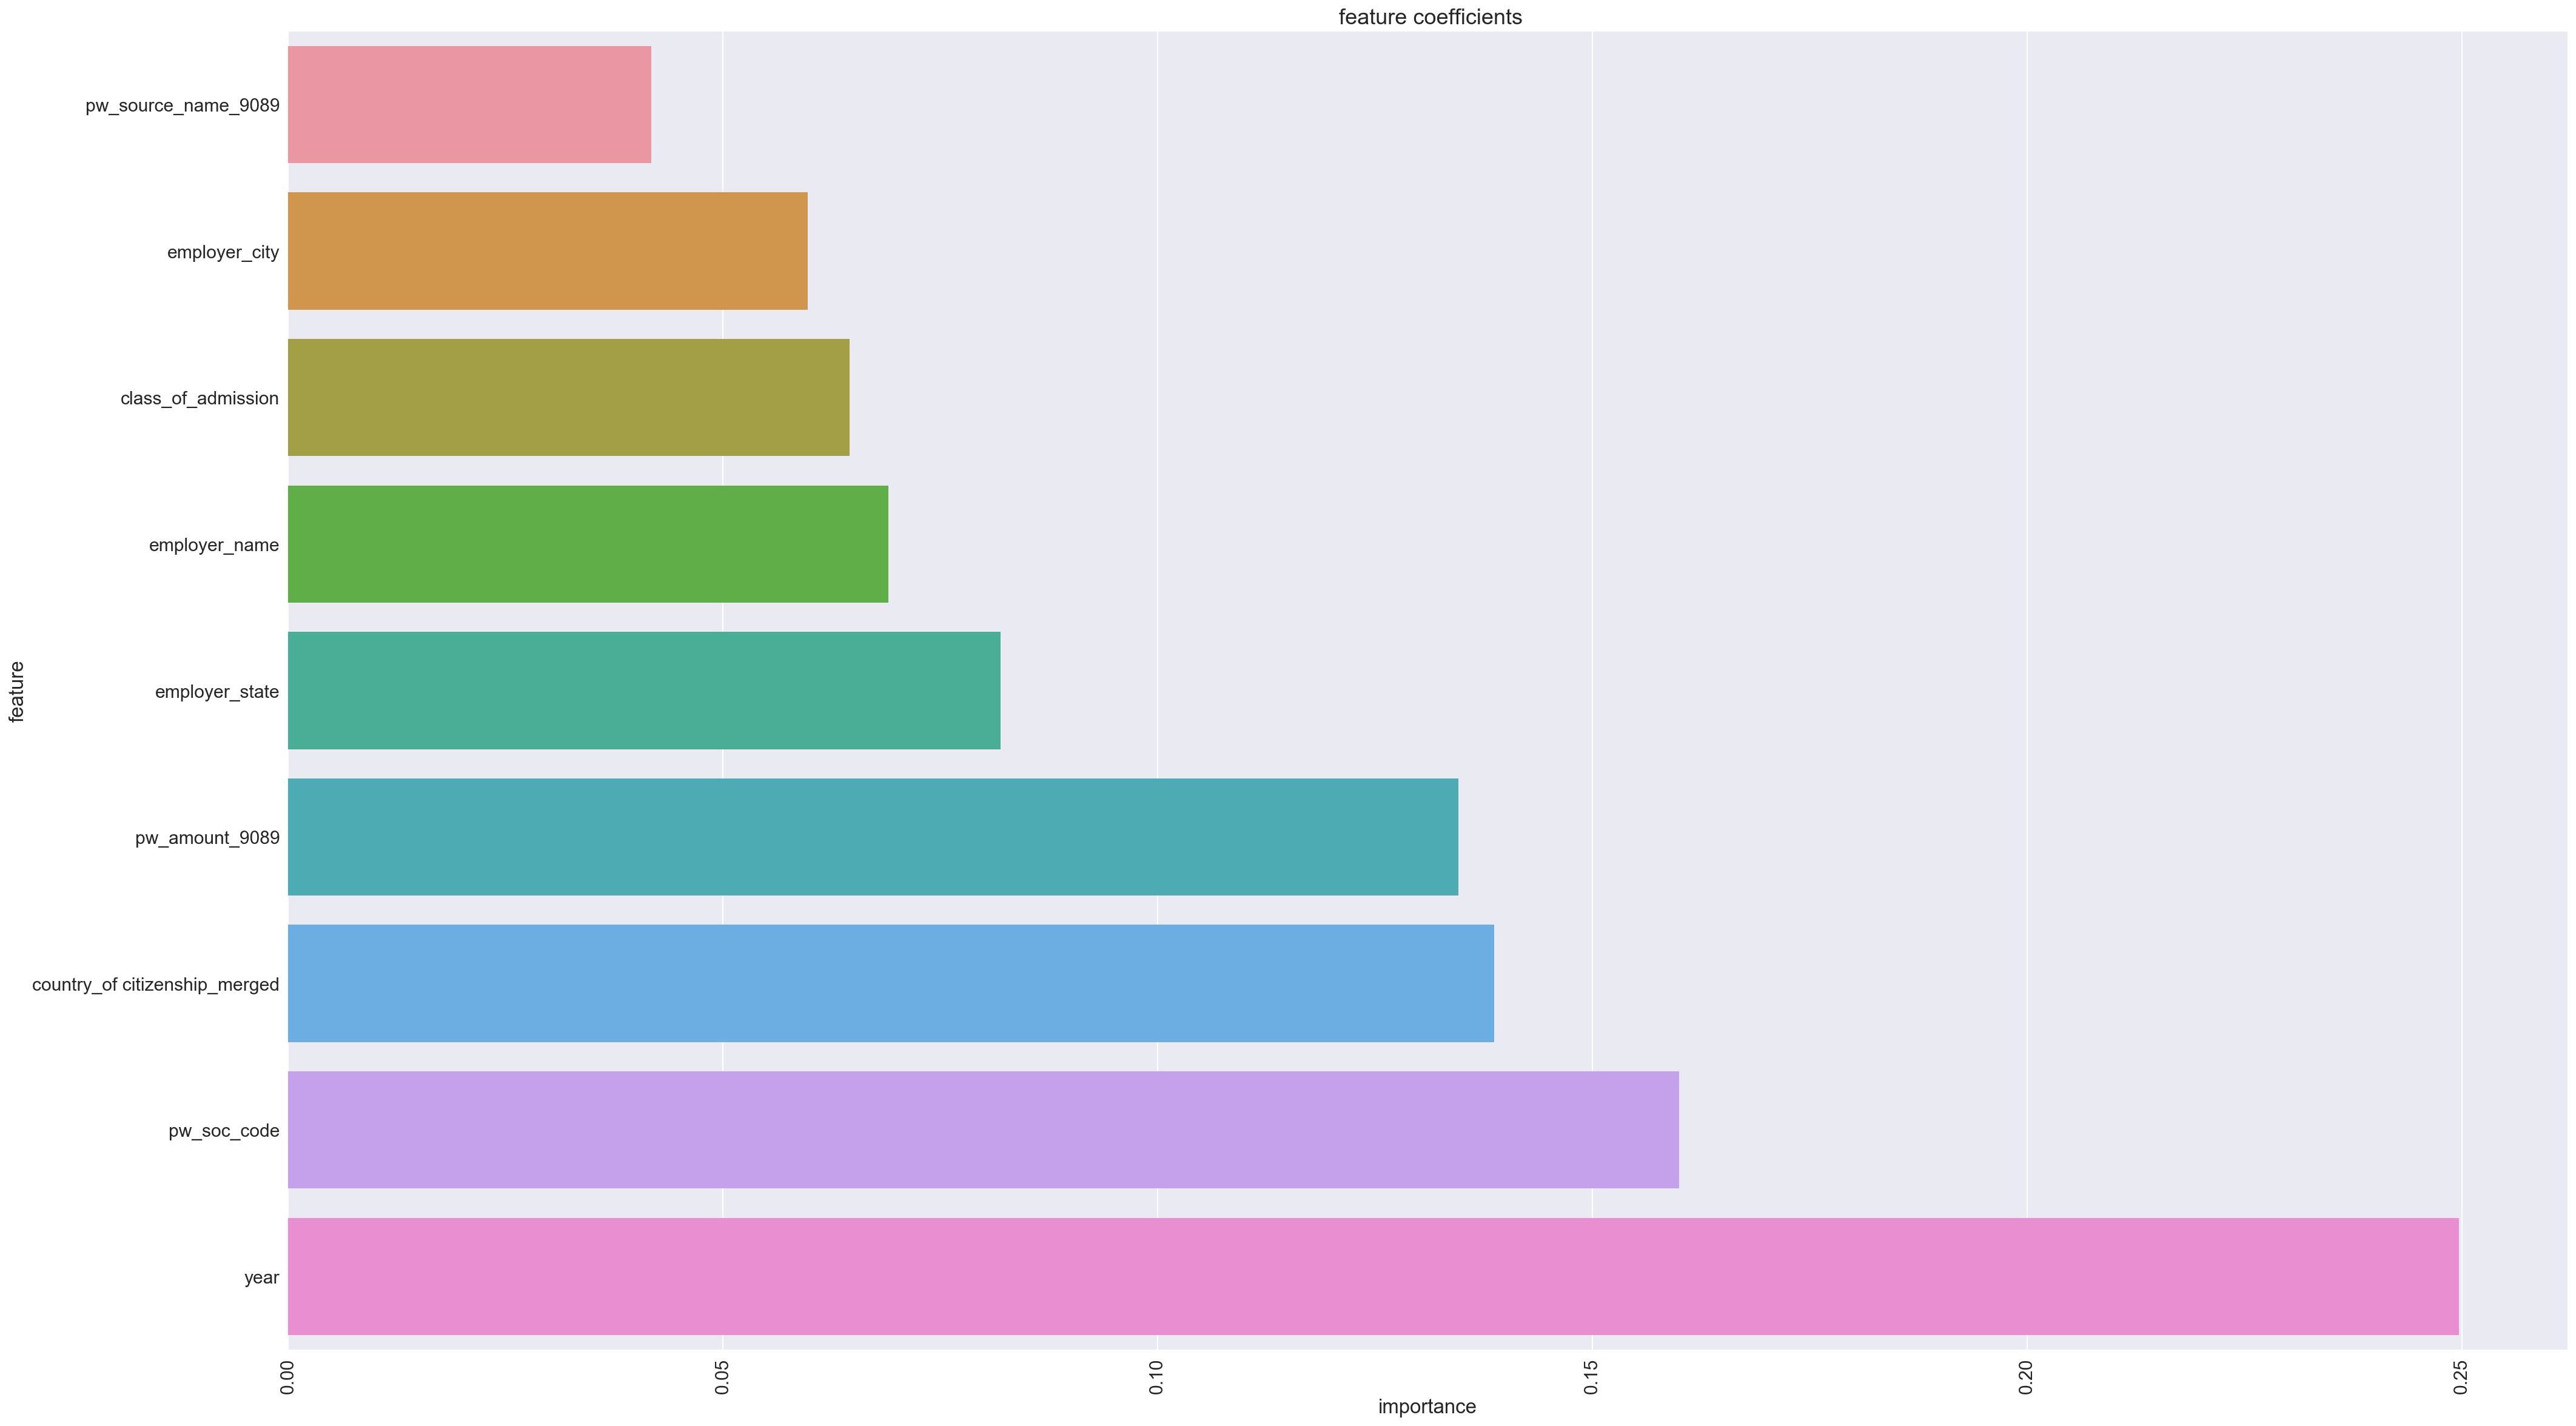

In [111]:
plt.figure(figsize=(30,20))
sns.set(font_scale=1.5)
sns.barplot(x='importance',y='feature',data=grid_reg_coefs_rf.sort_values('importance'))
plt.title(' feature coefficients')
plt.xticks(rotation=90)
plt.show()

In [122]:
Y_pp_rf = pd.DataFrame(y_pp_rf, columns=['class_0_pp','class_1_pp'])
Y_pp_rf.head()

,class_0_pp,class_1_pp
0,0.457092,0.542908
1,0.000000,1.000000
2,0.580000,0.420000
3,0.410364,0.589636
4,0.084000,0.916000


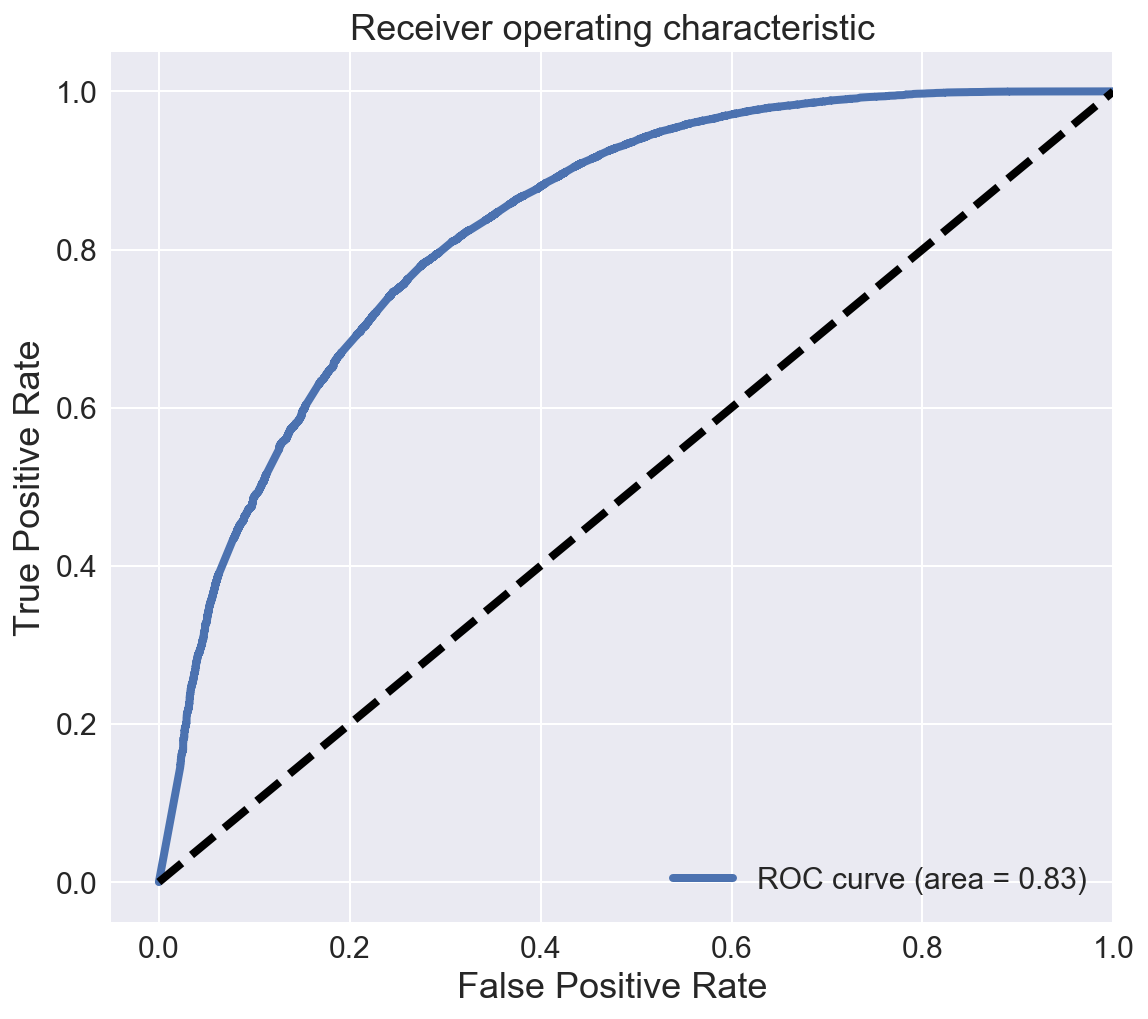

In [124]:
from sklearn.metrics import roc_curve, auc
# For class 1, find the area under the curve
fpr, tpr, _ = roc_curve(y_test, Y_pp_rf.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Gradient  Boosting

In [91]:

from sklearn.ensemble import GradientBoostingClassifier

#Defining range of parameters for Gradient Boosting Clssifier
param_grid = {'n_estimators': [100],
     'max_depth': [3],
     'random_state': [123],
     'learning_rate': [0.1]
    }



gra=GradientBoostingClassifier()wwwwww


In [92]:
%%time
grid_gra = GridSearchCV(estimator=gra, param_grid=param_grid, cv= 5, n_jobs=-1)
grid_gra.fit(x_train_res, y_train_res)

Wall time: 7min 11s


In [94]:
# examine the best model
print(grid_gra.best_score_)
print(grid_gra.best_params_)
gra_best = grid_gra.best_estimator_

0.8862494151433504
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 123}


In [113]:
y_pred_gra= grid_gra.predict(X_test)
y_pred_gra 

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [97]:
confusion_gra = confusion_matrix(y_test,y_pred_gra)
confusion_gra

array([[ 2402,  4045],
       [ 5486, 77109]], dtype=int64)

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gra))
# calculate testing accuracy
from sklearn import metrics
print('accuracy',metrics.accuracy_score(y_test, y_pred_gra))

             precision    recall  f1-score   support

          0       0.30      0.37      0.34      6447
          1       0.95      0.93      0.94     82595

avg / total       0.90      0.89      0.90     89042

accuracy 0.8929606253228813


In [125]:
y_pp_gra = grid_gra.predict_proba(X_test)

In [99]:
grid_reg_coefs_gra = pd.DataFrame({
        'feature':X.columns,
        'importance':gra_best.feature_importances_
    })

grid_reg_coefs_gra.sort_values('importance', inplace=True, ascending=False)
grid_reg_coefs_gra

,feature,importance
8,year,0.394556
5,pw_soc_code,0.130817
7,country_of citizenship_merged,0.125421
0,class_of_admission,0.101747
3,employer_state,0.078099
4,pw_amount_9089,0.064710
6,pw_source_name_9089,0.061362
2,employer_name,0.027710
1,employer_city,0.015577


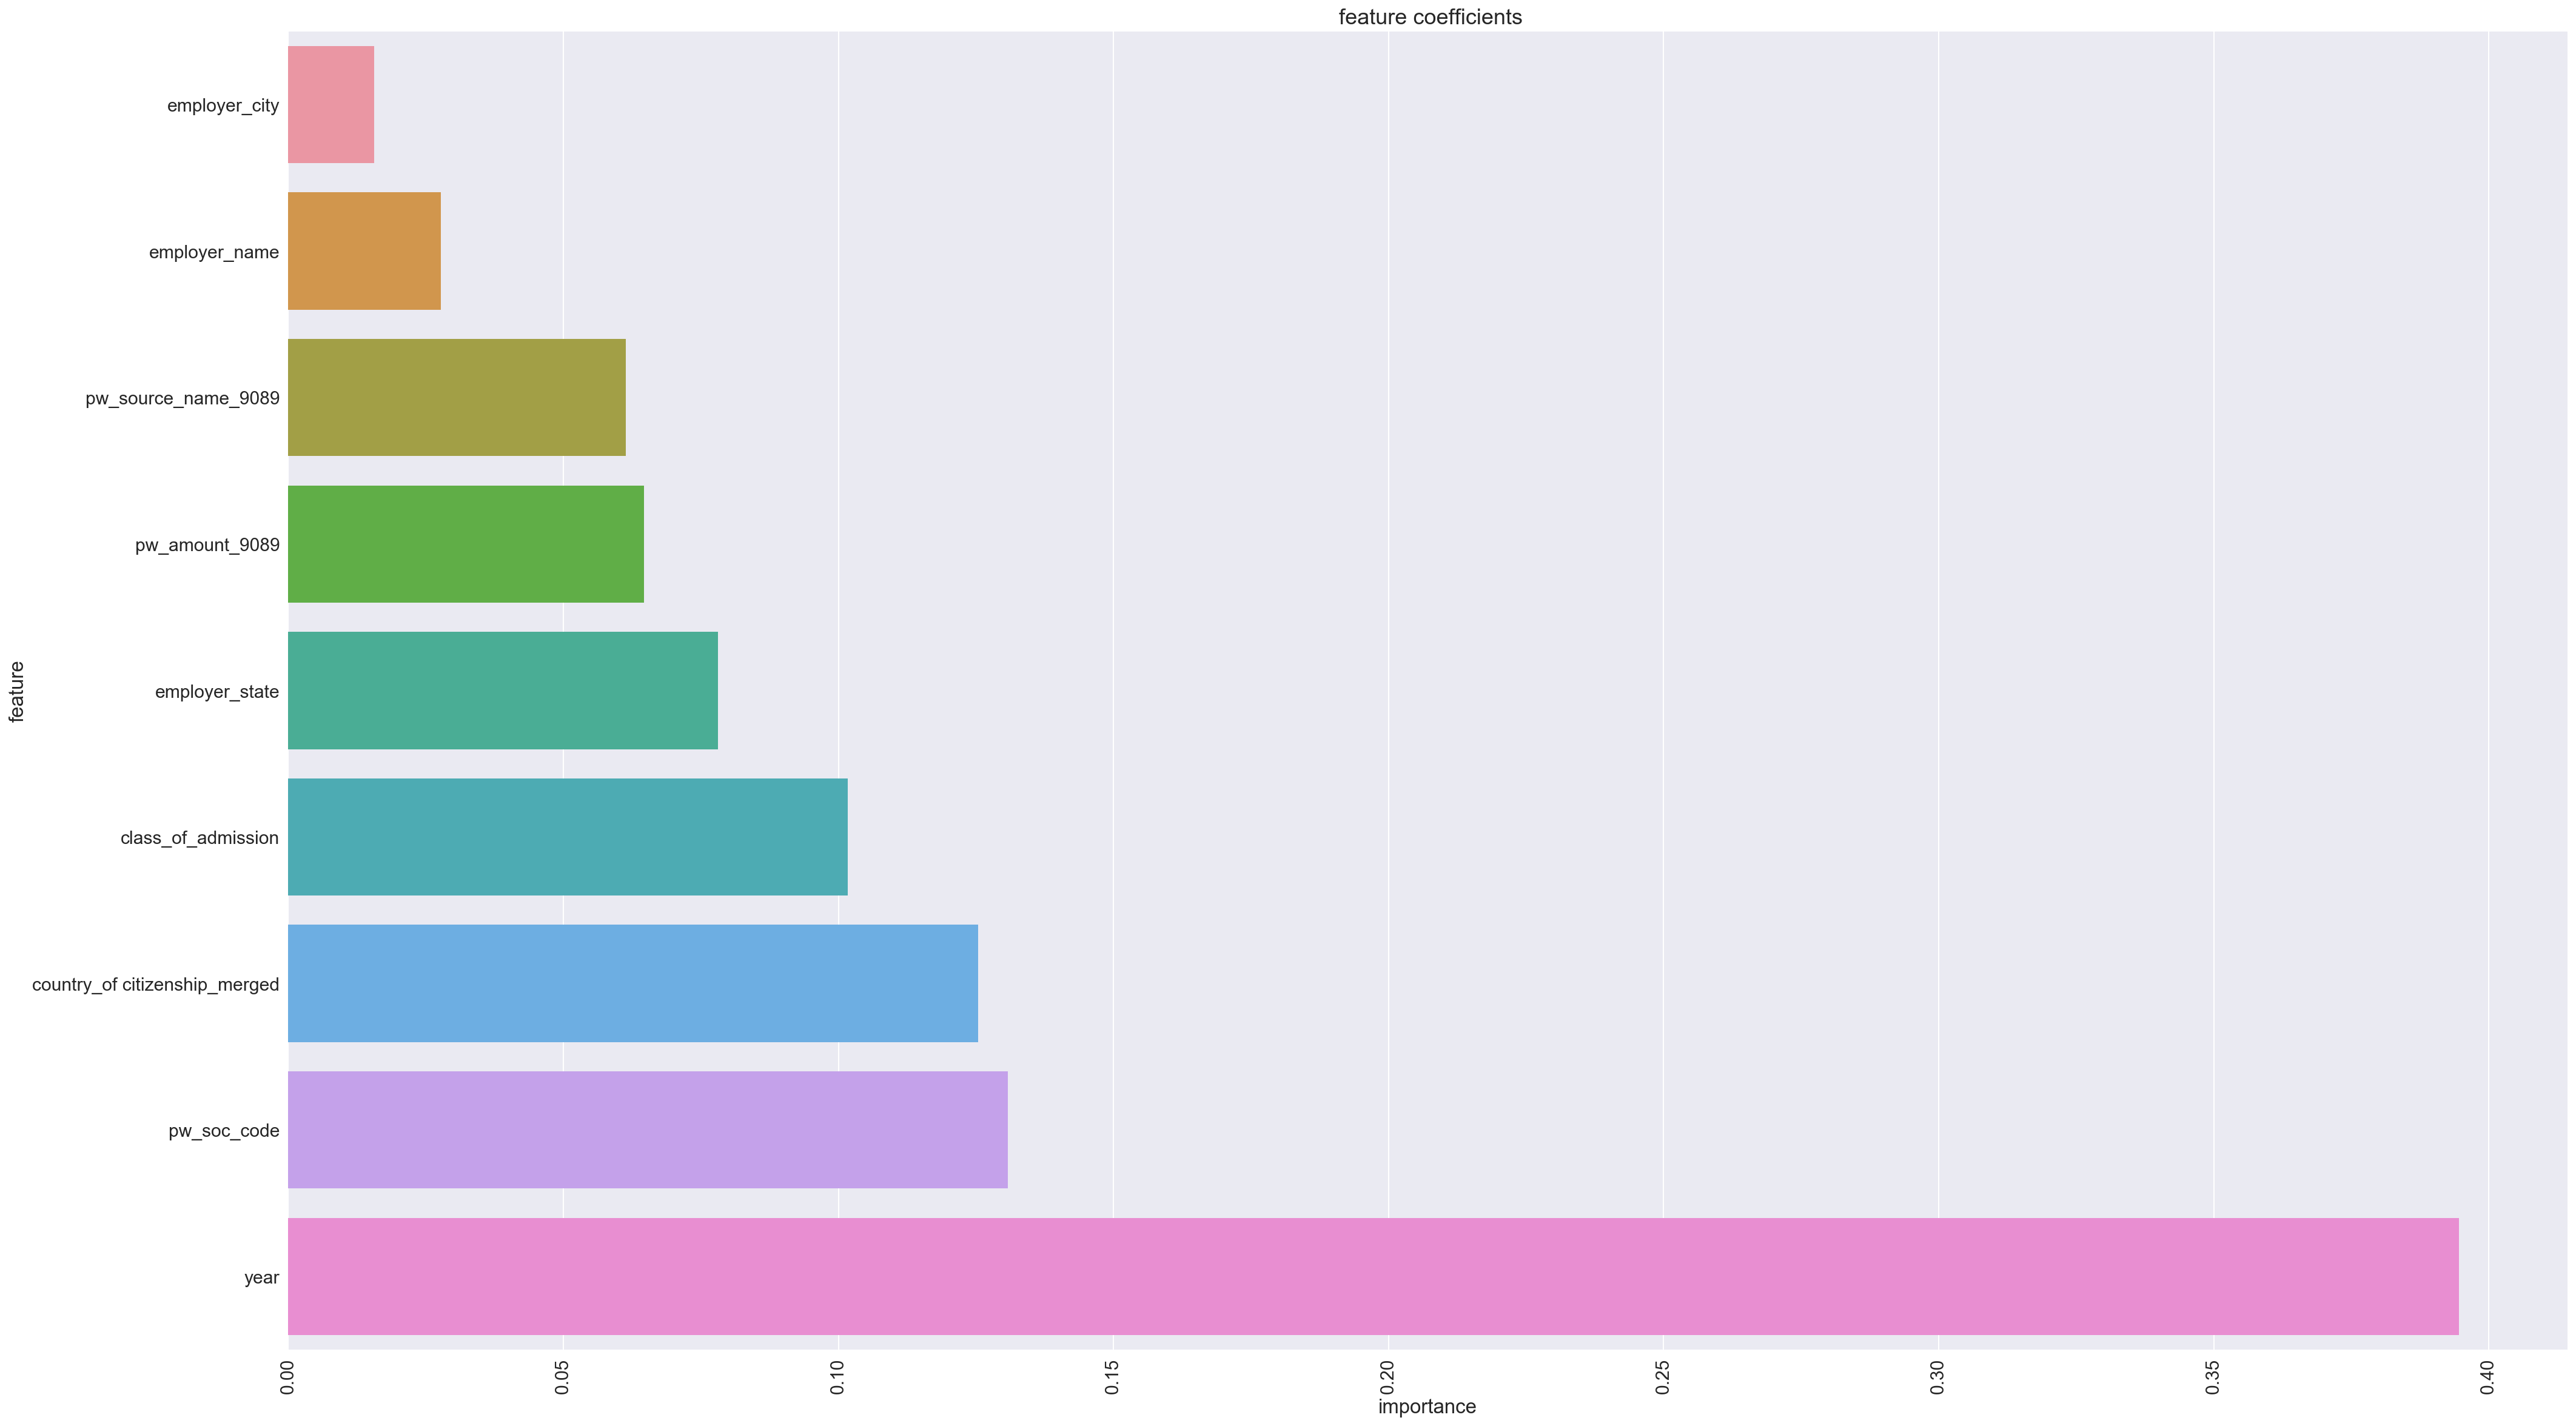

In [100]:
plt.figure(figsize=(30,20))
sns.set(font_scale=1.5)
sns.barplot(x='importance',y='feature',data=grid_reg_coefs_gra.sort_values('importance'))
plt.title(' feature coefficients')
plt.xticks(rotation=90)
plt.show()

In [126]:
Y_pp_gra = pd.DataFrame(y_pp_gra, columns=['class_0_pp','class_1_pp'])
Y_pp_gra.head()

,class_0_pp,class_1_pp
0,0.572601,0.427399
1,0.200690,0.799310
2,0.335970,0.664030
3,0.331463,0.668537
4,0.283175,0.716825


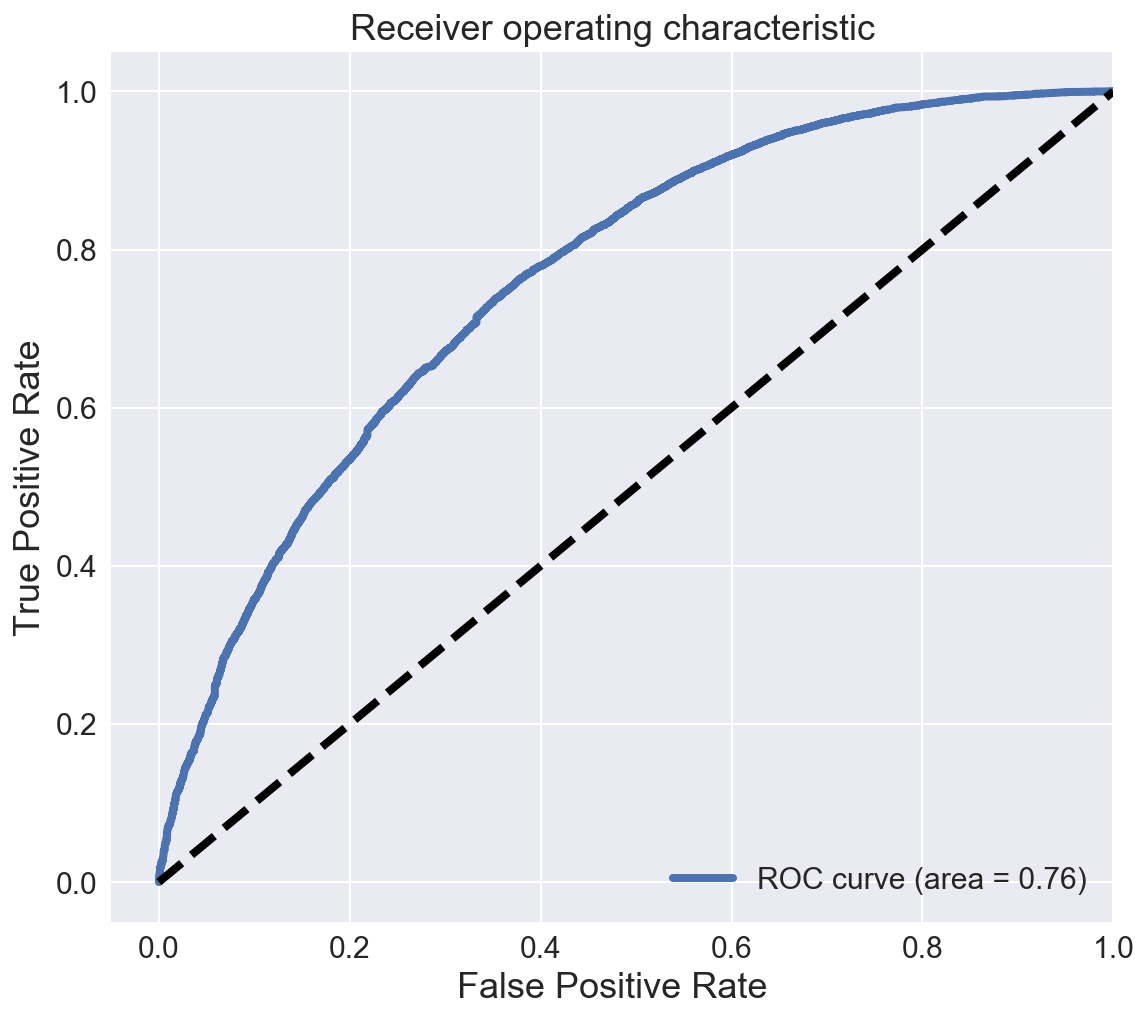

In [127]:
from sklearn.metrics import roc_curve, auc
# For class 1, find the area under the curve
fpr, tpr, _ = roc_curve(y_test, Y_pp_gra.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# summary

In [ ]:
f=pd.DataFrame({
        'Feature':X.columns,
        'gradient boosting':gra_best.feature_importances_,
        'decision tree':dtc_best.feature_importances_,
        'random forest':rf_best.feature_importances_,
    
    })

#f.sort_values('importance', inplace=True, ascending=False)


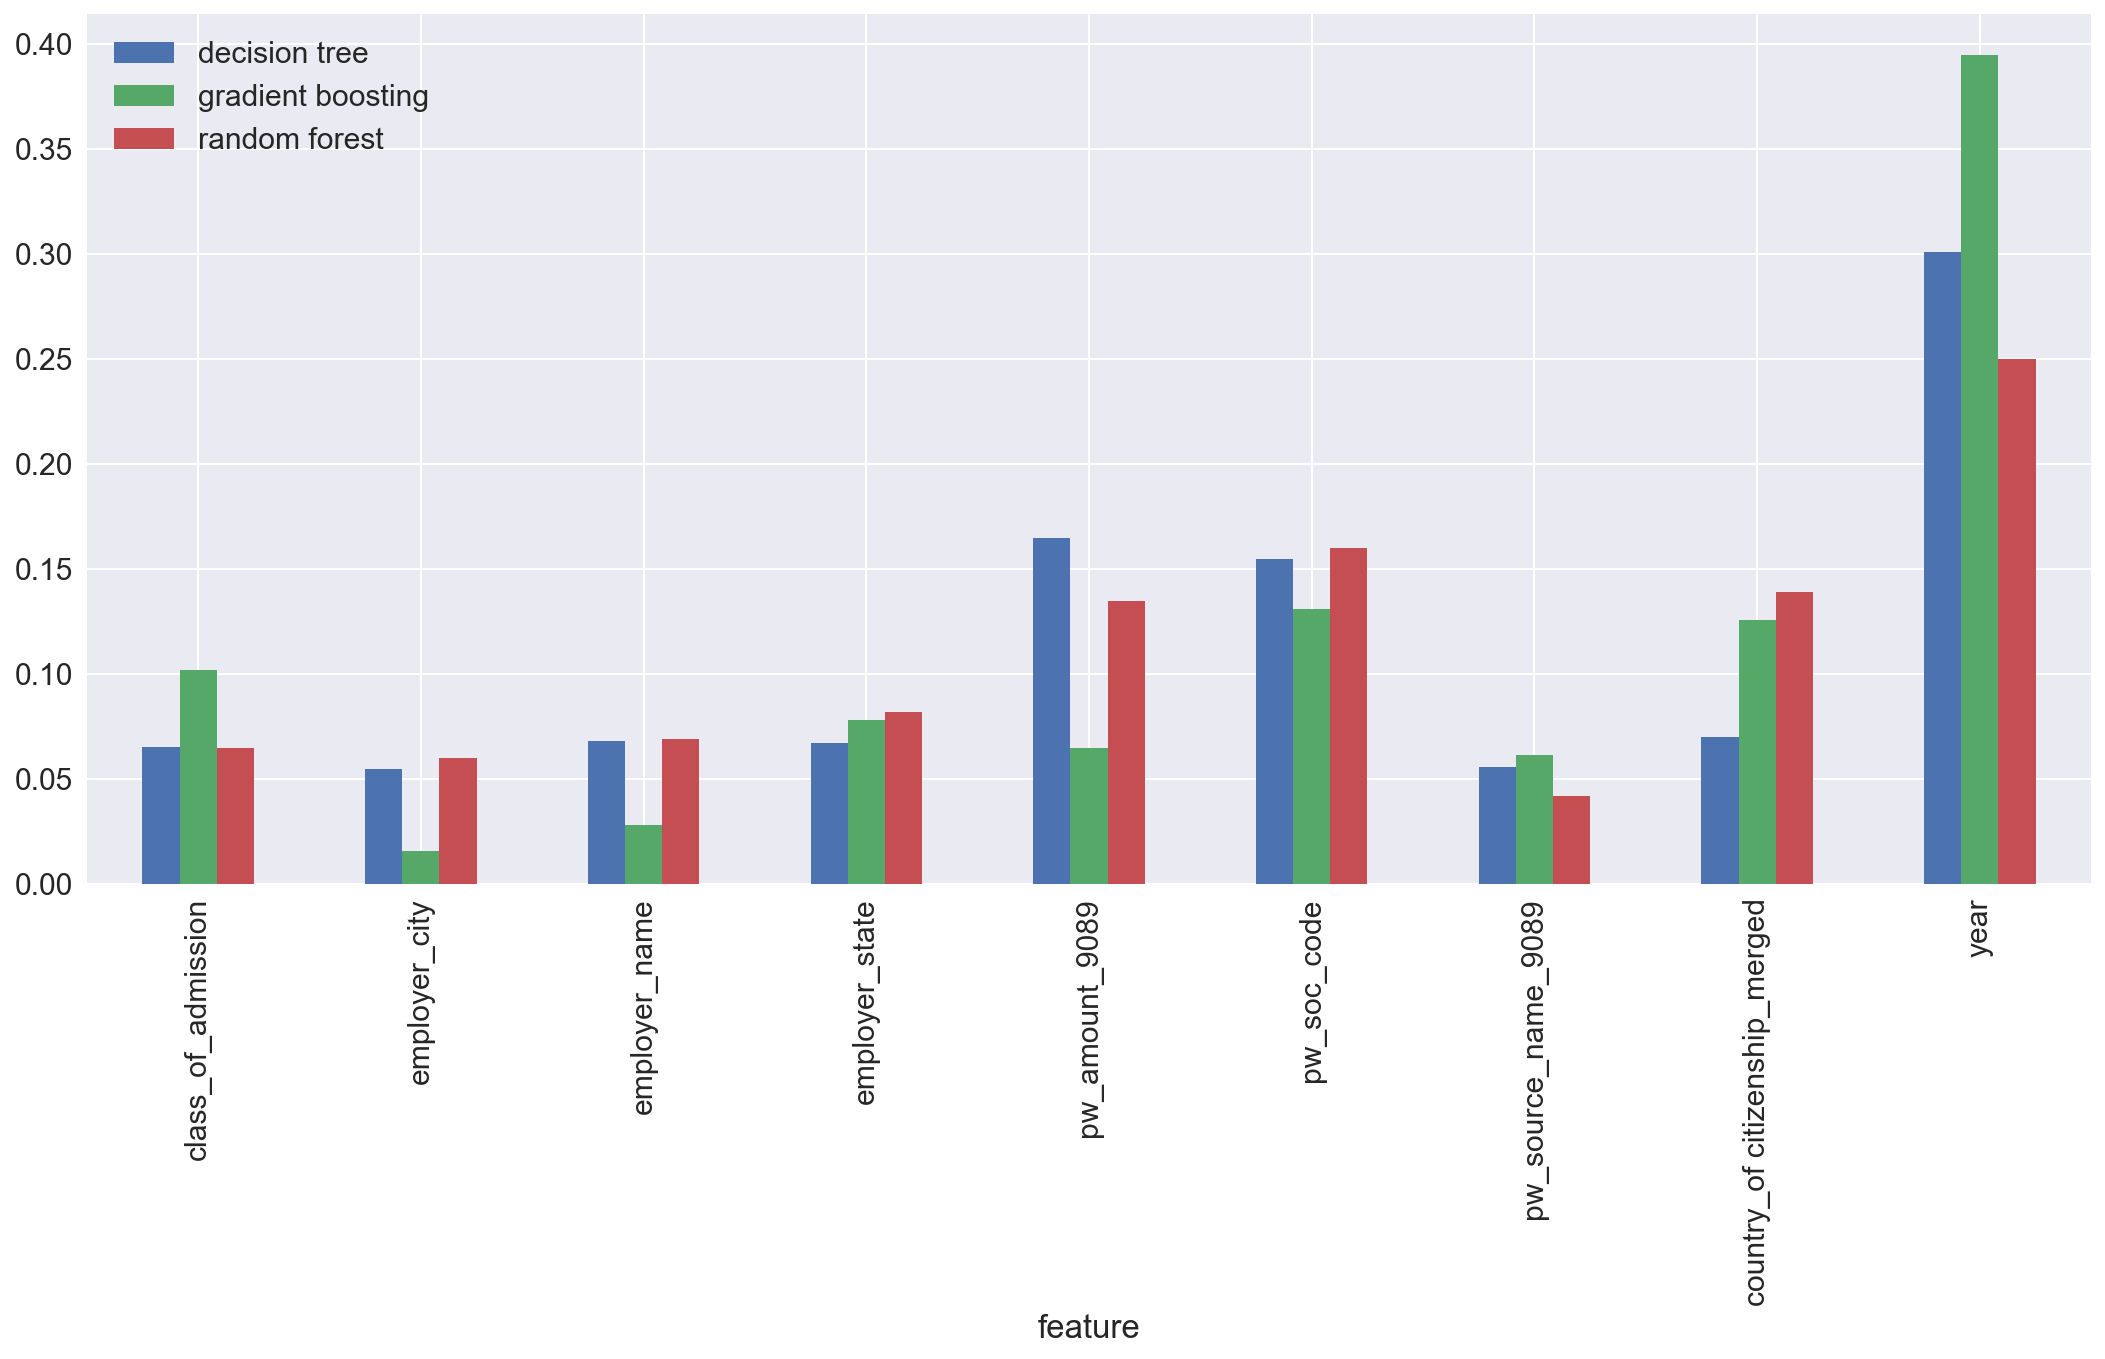

In [143]:
f.plot(x = "feature", kind='bar', figsize=(16,8))